In [48]:
import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.pyplot import figure
import fastf1 as ff1
from fastf1 import plotting
import time
from datetime import datetime, date, time, timedelta
from timple.timedelta import strftimedelta
from fastf1.core import Laps
import matplotlib.image as image
import matplotlib.ticker as ticker
import matplotlib.patches as patches
#enabling the cache for the data
ff1.Cache.clear_cache('F1Cache')
ff1.Cache.enable_cache('F1Cache')

#importing the data
#loading data in from session
session = ff1.get_session(2023, 'Hungary','Race')
session.load()
laps=session.laps
laps_uncleaned=laps.copy()
results=session.results
race=session

core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.2.8]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching track s

In [49]:
#settings where theres no limit to columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [50]:
#for loop that cleans the data because it has to run 4-5 times to normalize idk why lol
for lap in range(5):
    #turn LapTime into seconds from DD:HH:MM:SS
    laps['LapTime_seconds'] = laps['LapTime'].dt.total_seconds()

    #drop first lap for all drivers
    laps = laps.drop(laps[laps['LapNumber'] == 1].index)

    #drop all rows with NaN in LapTime_seconds
    laps = laps.dropna(subset=['LapTime_seconds'])

    laptimemean=laps['LapTime_seconds'].mean()
    laptimestd=laps['LapTime_seconds'].std()

    #drop all rows in laps with LapTime_seconds 3 std greater than the mean lap time
    laps = laps[laps['LapTime_seconds'] < (laptimemean + 3*laptimestd)]
    

    #doing the same for Sector1Time, Sector2Time, Sector3Time
    laps['Sector1Time_seconds'] = laps['Sector1Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector1Time_seconds'])
    laps['Sector2Time_seconds'] = laps['Sector2Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector2Time_seconds'])
    laps['Sector3Time_seconds'] = laps['Sector3Time'].dt.total_seconds()
    laps = laps.dropna(subset=['Sector3Time_seconds'])
    
    #finding the mean and std of the Sector times
    sector1mean=laps['Sector1Time_seconds'].mean()
    sector1std=laps['Sector1Time_seconds'].std()
    sector2mean=laps['Sector2Time_seconds'].mean()
    sector2std=laps['Sector2Time_seconds'].std()
    sector3mean=laps['Sector3Time_seconds'].mean()
    sector3std=laps['Sector3Time_seconds'].std()

    #drop all rows in laps with Sector1Time 3 std greater than the mean sector time
    laps = laps[laps['Sector1Time_seconds'] < (sector1mean + 3*sector1std)]
    #drop all rows in laps with Sector2Time 3 std greater than the mean sector time
    laps = laps[laps['Sector2Time_seconds'] < (sector2mean + 3*sector2std)]
    #drop all rows in laps with Sector3Time 3 std greater than the mean sector time
    laps = laps[laps['Sector3Time_seconds'] < (sector3mean + 3*sector3std)]

In [51]:
#Making laps fuel corrected
laps["LapTime_fuelCorrected"] = laps["LapTime_seconds"] - (
    3.3
    * (laps["LapNumber"].max() - laps["LapNumber"])
    / laps["LapNumber"].max()
    )

## Load in every drivers telemetry data

In [52]:
ver = laps.pick_driver('VER')
ham = laps.pick_driver('HAM')
gas = laps.pick_driver('GAS')
lec = laps.pick_driver('LEC')
# alo = laps.pick_driver('ALO')
sai = laps.pick_driver('SAI')
# oco = laps.pick_driver('OCO')
nor = laps.pick_driver('NOR')
rus = laps.pick_driver('RUS')
tsu = laps.pick_driver('TSU')
str = laps.pick_driver('STR')
bot = laps.pick_driver('BOT')
per = laps.pick_driver('PER')
zho = laps.pick_driver('ZHO')
sar= laps.pick_driver('SAR')
mag= laps.pick_driver('MAG')
pia= laps.pick_driver('PIA')
hul= laps.pick_driver('HUL')
alb= laps.pick_driver('ALB')
ric= laps.pick_driver('RIC')

#load in each drivers laps and then put it all into one dataframe make sure to add the Driver name to the dataframe for their respective laps

#do this for all of the drivers 
vertel=ver.get_car_data().add_distance()
vertel['Driver'] = 'VER'
hamtel=ham.get_car_data().add_distance()
hamtel['Driver'] = 'HAM'
lectel=lec.get_car_data().add_distance()
lectel['Driver'] = 'LEC'
alotel=alo.get_car_data().add_distance()
alotel['Driver'] = 'ALO'
saitel=sai.get_car_data().add_distance()
saitel['Driver'] = 'SAI'
# gastel=gas.get_car_data().add_distance()
# gastel['Driver'] = 'GAS'
# ocotel=oco.get_car_data().add_distance()
# ocotel['Driver'] = 'OCO'
nortel=nor.get_car_data().add_distance()
nortel['Driver'] = 'NOR'
rustel=rus.get_car_data().add_distance()
rustel['Driver'] = 'RUS'
tsutel=tsu.get_car_data().add_distance()
tsutel['Driver'] = 'TSU'
strtell=str.get_car_data().add_distance()
strtell['Driver'] = 'STR'
bottel=bot.get_car_data().add_distance()
bottel['Driver'] = 'BOT'
pertel=per.get_car_data().add_distance()
pertel['Driver'] = 'PER'
zhotel=zho.get_car_data().add_distance()
zhotel['Driver'] = 'ZHO'
sartel=sar.get_car_data().add_distance()
sartel['Driver'] = 'SAR'
magtel=mag.get_car_data().add_distance()
magtel['Driver'] = 'MAG'
piatel=pia.get_car_data().add_distance()
piatel['Driver'] = 'PIA'
hultel=hul.get_car_data().add_distance()
hultel['Driver'] = 'HUL'
albtel=alb.get_car_data().add_distance()
albtel['Driver'] = 'ALB'
rictel=ric.get_car_data().add_distance()
rictel['Driver'] = 'RIC'

#put all of the drivers into one dataframe
drivers_telemetry = pd.concat([vertel, hamtel, lectel, alotel, saitel, 
                                nortel, rustel, tsutel, strtell, bottel, pertel, zhotel, 
                                sartel, magtel, piatel, hultel, albtel, rictel], axis=0)

drivers_telemetry.head()

Date    RPM  Speed  nGear                   Time  \
0 2023-07-23 13:04:34.587  11384    254      6 0 days 00:00:00.269000   
1 2023-07-23 13:04:34.747  11496    256      6 0 days 00:00:00.429000   
2 2023-07-23 13:04:34.947  11575    259      6 0 days 00:00:00.629000   
3 2023-07-23 13:04:35.267  11331    264      6 0 days 00:00:00.949000   
4 2023-07-23 13:04:35.427  10661    265      6 0 days 00:00:01.109000   

[5 rows x 12 columns]

In [82]:
#find the mean of the speed column
mean_speed = drivers_telemetry['Speed'].mean()

#find the mean of the rpm column
mean_rpm = drivers_telemetry['RPM'].mean()

#find the percentage that throttle is equal to 100
throttle_100 = drivers_telemetry[drivers_telemetry['Throttle'] == 100].shape[0] / drivers_telemetry.shape[0] * 100
throttle_100 = round(throttle_100, 2)

#find the percentage that brake is equal to True
brake_100 = drivers_telemetry[drivers_telemetry['Brake'] == True].shape[0] / drivers_telemetry.shape[0] * 100
brake_100 = round(brake_100, 2)

drivers_telemetry_grouped = drivers_telemetry.groupby('Driver').mean().reset_index()

#create a new stat called Speed+ that is the difference between the mean speed and the driver's Speed
drivers_telemetry['Speed+'] = mean_speed - drivers_telemetry_grouped['Speed']

#create a new stat called RPM+ that is the difference between the mean RPM and the driver's RPM
drivers_telemetry['RPM+'] = mean_rpm - drivers_telemetry_grouped['RPM']

#create a new stat called FlatOut+ that is the difference between the mean FlatOut and the driver's FlatOut
drivers_telemetry['FlatOut+'] = throttle_100 - drivers_telemetry_grouped['Throttle']

#create a new stat called Brake+ that is the difference between the mean Brake and the driver's Brake
drivers_telemetry['Brake+'] = brake_100 - drivers_telemetry_grouped['Brake']

#drop the float points on the new stats
drivers_telemetry = drivers_telemetry.round(0)

#make a new dataframe with the new stats
new_stats = drivers_telemetry[['Speed+', 'RPM+', 'FlatOut+', 'Brake+','Driver']]

In [84]:
new_stats

Speed+   RPM+  Brake+ Driver
0         1.0   55.0    23.0    VER
1        -0.0   72.0    23.0    VER
2         1.0   63.0    23.0    VER
3        -1.0  386.0    23.0    VER
4         1.0   19.0    23.0    VER
5        -1.0 -218.0    23.0    VER
21096     NaN    NaN     NaN    RIC
21097     NaN    NaN     NaN    RIC
21098     NaN    NaN     NaN    RIC
21099     NaN    NaN     NaN    RIC
21100     NaN    NaN     NaN    RIC
21101     NaN    NaN     NaN    RIC

[390480 rows x 5 columns]

In [ ]:
#make flat out plus leaderboard

In [54]:
#list of drivers initials
drivers=['ver','ham','gas','lec','alo','sai','oco','nor','alo','zho','rus','tsu','SAR','mag','hul','pia','sto','bot','per','alb','ric']
#creating a stat deltaS1+ which is sector1mean-Sector1Time_seconds
laps['deltaS1+']=((sector1mean-laps['Sector1Time_seconds'])*100).round()#finding the delta between the mean and the sector time
#creating a stat deltaS2+ which is sector2mean-Sector2Time_seconds
laps['deltaS2+']=((sector2mean-laps['Sector2Time_seconds'])*100).round()
#creating a stat deltaS3+ which is sector3mean-Sector3Time_seconds
laps['deltaS3+']=((sector3mean-laps['Sector3Time_seconds'])*100).round()


#drop the float point from the deltaS1+ and deltaS2+ and deltaS3+
laps['deltaS1+']=laps['deltaS1+'].astype(int)
laps['deltaS2+']=laps['deltaS2+'].astype(int)
laps['deltaS3+']=laps['deltaS3+'].astype(int)

#make a new data frame called secPlus that has the drivers and the deltaS1+, deltaS2+, deltaS3+
secPlus=laps[['Driver','deltaS1+','deltaS2+','deltaS3+']]

#creating a dataframe that has the drivers and their average deltaS1+, deltaS2+, deltaS3+ scores
secPlusScores=secPlus.groupby('Driver').mean().reset_index()

#round deltaS1+,deltaS2+,deltaS3+ to the nearest integer and then remove the float point
secPlusScores['deltaS1+']=secPlusScores['deltaS1+'].round(0).astype(int)
secPlusScores['deltaS2+']=secPlusScores['deltaS2+'].round(0).astype(int)
secPlusScores['deltaS3+']=secPlusScores['deltaS3+'].round(0).astype(int)

secPlusScores.head(2)

#seperate the data into the drivers and the deltaS1+, deltaS2+, deltaS3+
sector1scores=secPlusScores[['Driver','deltaS1+']].sort_values(by='deltaS1+',ascending=False)
sector2scores=secPlusScores[['Driver','deltaS2+']].sort_values(by='deltaS2+',ascending=False)
sector3scores=secPlusScores[['Driver','deltaS3+']].sort_values(by='deltaS3+',ascending=False)

In [55]:
#show sector1scores,sector2scores,sector3scores side by side
from IPython.display import display_html 

df1_styler = sector1scores.style.set_table_attributes("style='display:inline',").set_caption('Delta Sector1+')
df2_styler = sector2scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector2+')
df3_styler = sector3scores.style.set_table_attributes("style='display:inline'").set_caption('Delta Sector3+')
#hide the index
df1_styler.hide_index()
df2_styler.hide_index()
df3_styler.hide_index()
display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)


Delta Sector1+ 
 
 
 Driver 
 deltaS1+ 
 
 
 
 
 VER 
 27 
 
 
 PER 
 19 
 
 
 SAI 
 9 
 
 
 LEC 
 4 
 
 
 RIC 
 3 
 
 
 NOR 
 2 
 
 
 STR 
 1 
 
 
 ALO 
 1 
 
 
 RUS 
 0 
 
 
 HAM 
 -1 
 
 
 ALB 
 -6 
 
 
 PIA 
 -6 
 
 
 HUL 
 -6 
 
 
 BOT 
 -7 
 
 
 SAR 
 -10 
 
 
 TSU 
 -11 
 
 
 ZHO 
 -12 
 
 
 MAG 
 -16 
 
 
 

 
 Delta Sector2+ 
 
 
 Driver 
 deltaS2+ 
 
 
 
 
 VER 
 53 
 
 
 NOR 
 45 
 
 
 HAM 
 38 
 
 
 LEC 
 25 
 
 
 PER 
 25 
 
 
 PIA 
 24 
 
 
 RUS 
 17 
 
 
 SAI 
 11 
 
 
 ALO 
 10 
 
 
 STR 
 -4 
 
 
 ALB 
 -21 
 
 
 BOT 
 -21 
 
 
 RIC 
 -28 
 
 
 SAR 
 -28 
 
 
 ZHO 
 -37 
 
 
 TSU 
 -39 
 
 
 MAG 
 -46 
 
 
 HUL 
 -48 
 
 
 

 
 Delta Sector3+ 
 
 
 Driver 
 deltaS3+ 
 
 
 
 
 VER 
 34 
 
 
 HAM 
 26 
 
 
 PER 
 20 
 
 
 NOR 
 15 
 
 
 RUS 
 14 
 
 
 ALO 
 7 
 
 
 PIA 
 3 
 
 
 SAI 
 1 
 
 
 LEC 
 -2 
 
 
 ALB 
 -7 
 
 
 RIC 
 -8 
 
 
 STR 
 -9 
 
 
 BOT 
 -9 
 
 
 TSU 
 -13 
 
 
 ZHO 
 -13 
 
 
 HUL 
 -18 
 
 
 SAR 
 -22 
 
 
 MAG 
 -30

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.
 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


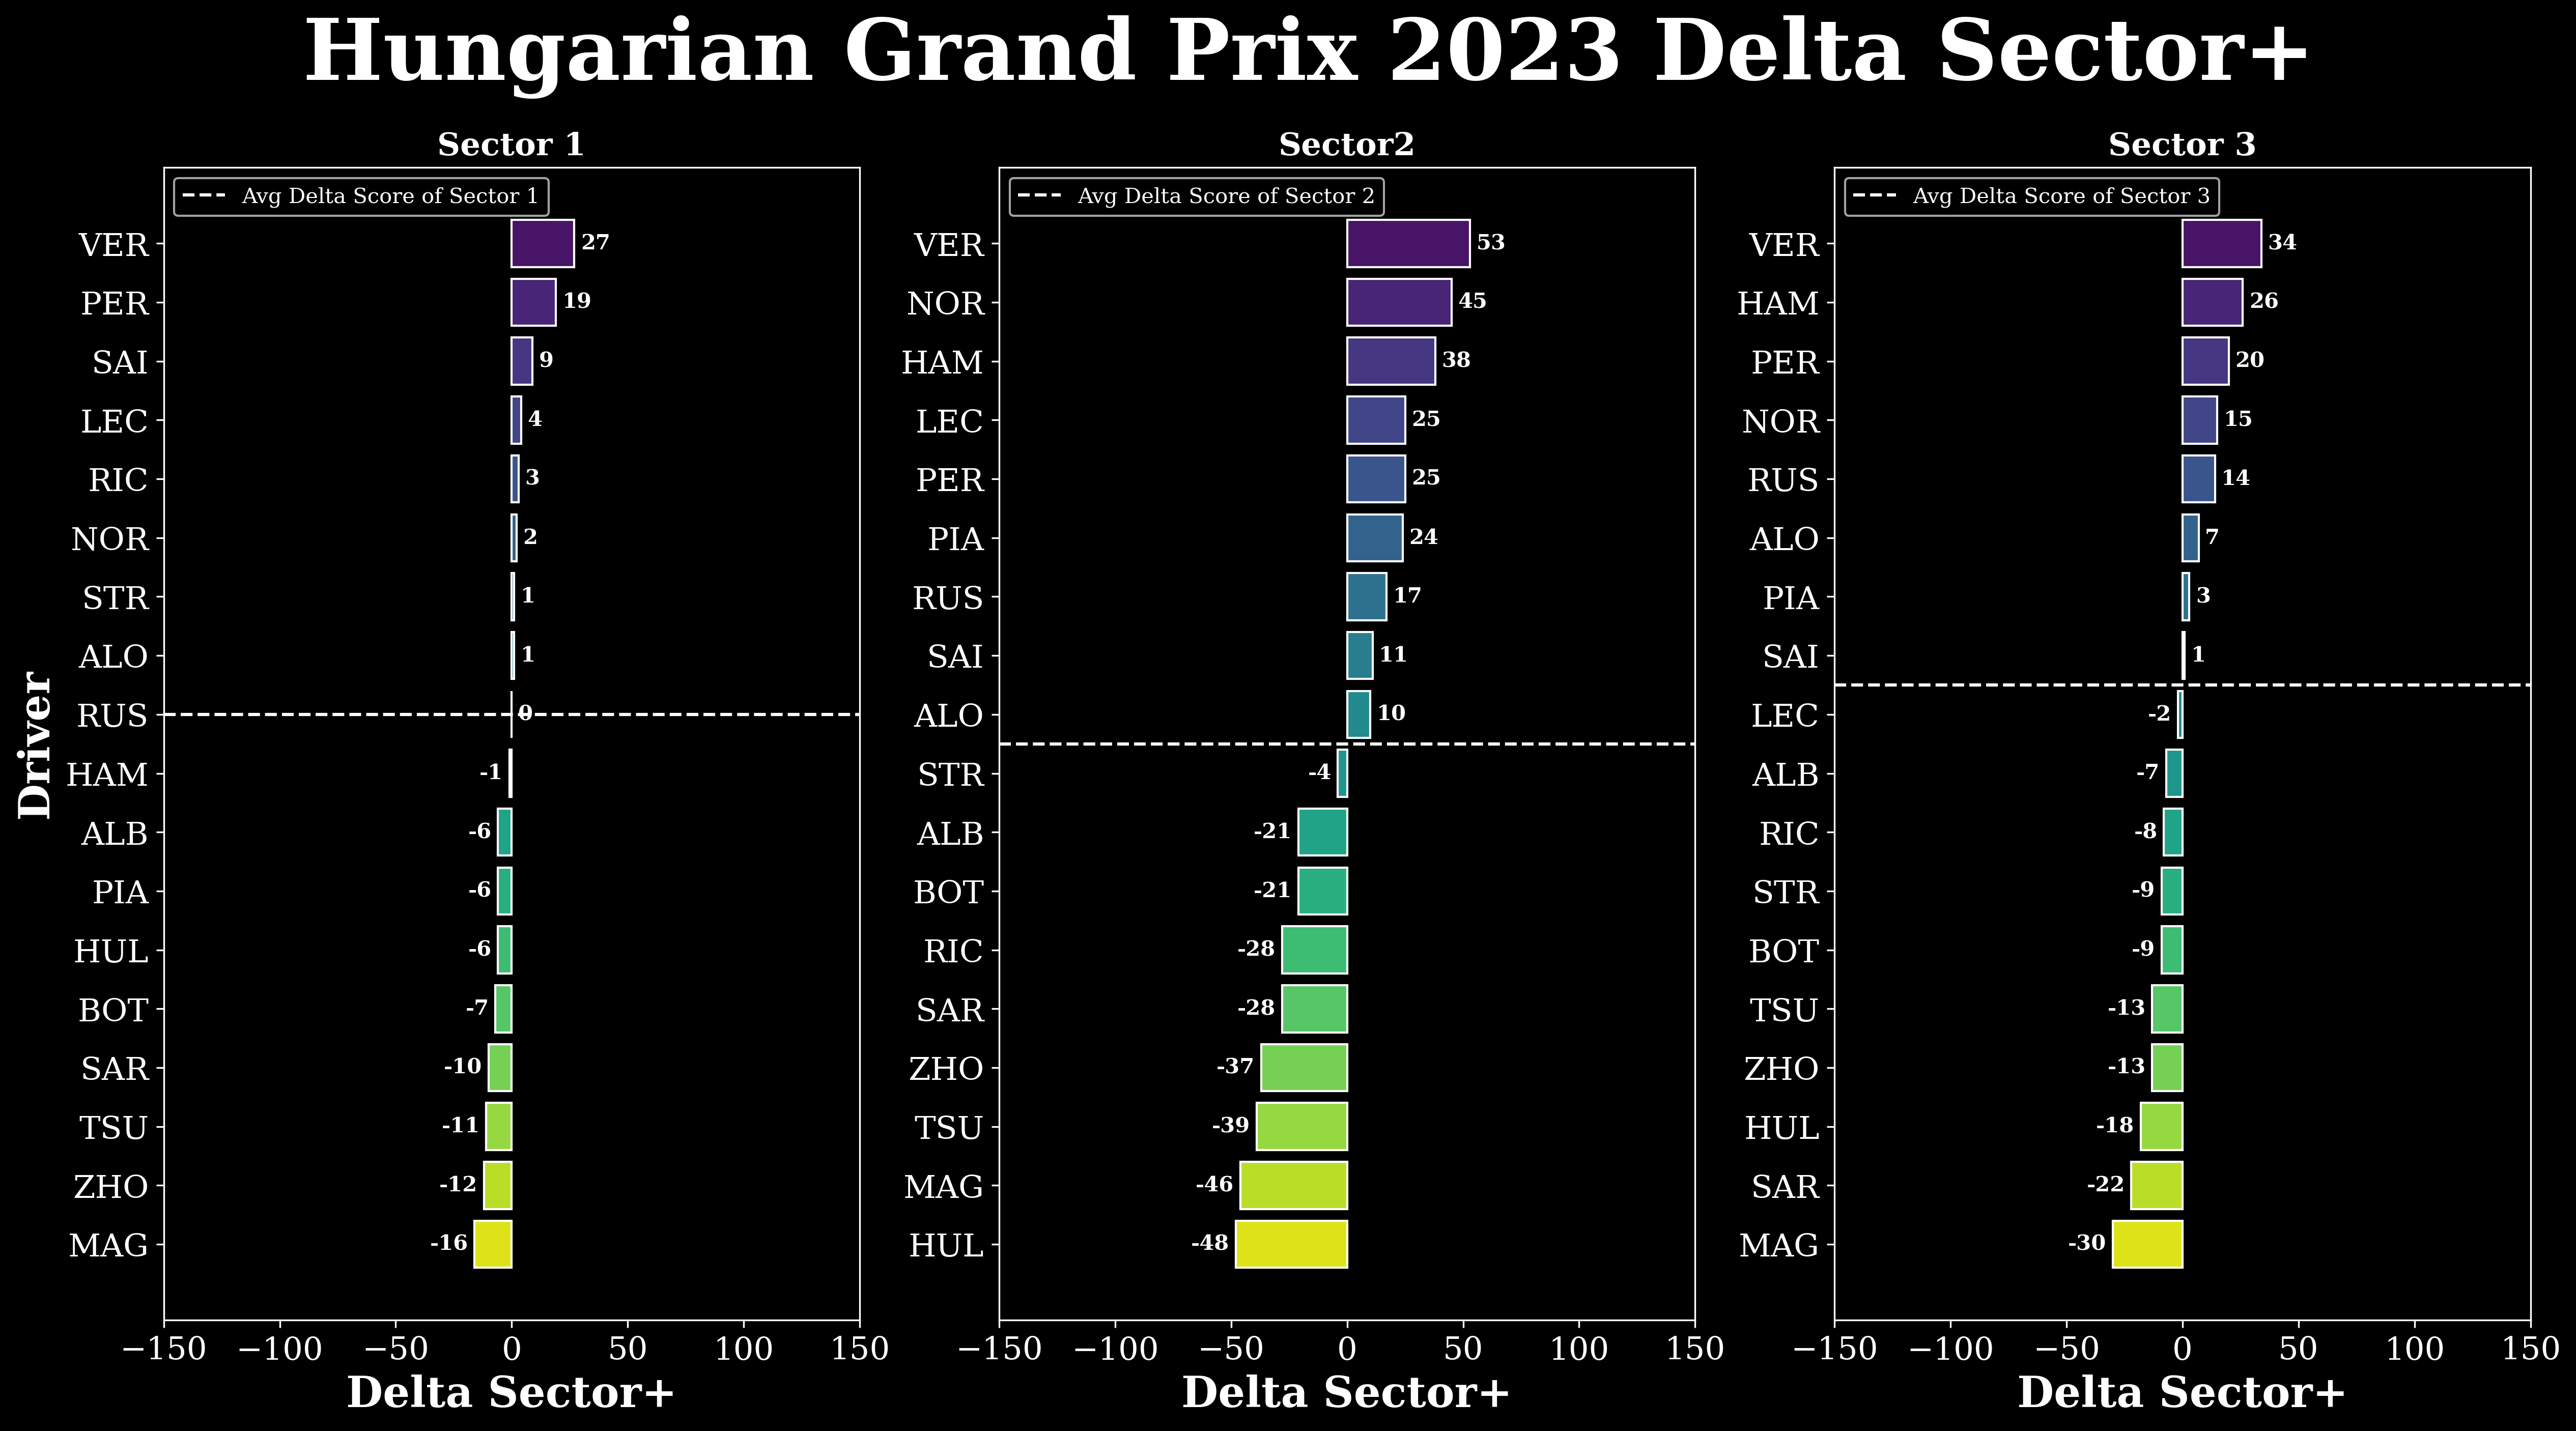

In [56]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.suptitle(f'{race.weekend.name} {race.weekend.year} Delta Sector+', fontsize=40, fontweight='bold')

#create a color palette for seaborn that goes from yellow to green to purple
colors=['#FFF817','#EDDC26','#37AB16','#69359C']

#bar plot for sector1
pd1=axs[0].barh(sector1scores['Driver'],sector1scores['deltaS1+'],edgecolor='white',color=sns.color_palette("viridis", len(sector1scores['Driver'])))
axs[0].set_title('Sector 1', fontsize=15, fontweight='bold')
axs[0].invert_yaxis()
axs[0].bar_label(pd1,padding=3,fontweight='bold')

#find where Driver deltaS1+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector1scores['deltaS1+']):
    if v == 0:
        axs[0].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
    elif v < 0:
        axs[0].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 1')
        break
axs[0].tick_params(labelsize=15)
axs[0].set_xlim(-150,150)
axs[0].set_xlabel('Delta Sector+', fontsize=20, fontweight='bold')
axs[0].legend(loc='upper left', fontsize=10)
axs[0].set_ylabel('Driver', fontsize=20, fontweight='bold')

#bar plot for sector2
pd2=axs[1].barh(sector2scores['Driver'],sector2scores['deltaS2+'],edgecolor='white',color=sns.color_palette("viridis", len(sector2scores['Driver'])))
axs[1].set_title('Sector2', fontsize=15, fontweight='bold')
axs[1].invert_yaxis()
axs[1].bar_label(pd2,padding=3,fontweight='bold')

#find where Driver deltaS2+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector2scores['deltaS2+']):
    if v == 0:
        axs[1].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
    elif v < 0:
        axs[1].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 2')
        break
axs[1].tick_params(labelsize=15)
axs[1].set_xlim(-150,150)
axs[1].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[1].legend(loc='upper left', fontsize=10)


#bar plot for sector3
pd3=axs[2].barh(sector3scores['Driver'],sector3scores['deltaS3+'],edgecolor='white',color=sns.color_palette("viridis", len(sector3scores['Driver'])))
axs[2].set_title('Sector 3', fontsize=15, fontweight='bold')
axs[2].invert_yaxis()
axs[2].bar_label(pd3,padding=3,fontweight='bold')

#find where Driver deltaS3+ is negative and put a horizontal line right above that point
for i, v in enumerate(sector3scores['deltaS3+']):
    if v == 0:
        axs[2].axhline(i, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
    elif v < 0:
        axs[2].axhline(i-.5, color='white', linestyle='--',label='Avg Delta Score of Sector 3')
        break
axs[2].tick_params(labelsize=15)

#set the x axis ticks to -150 to 150
axs[2].set_xlim(-150,150)
axs[2].set_xlabel('Delta Sector+',fontsize=20,fontweight='bold')
axs[2].legend(loc='upper left', fontsize=10)

plt.savefig(f'F1Plots/{race.weekend.name} {race.weekend.year}DeltaSectorPlusBarChart.png')
plt.show()

## Driver Scorecard

In [57]:
#load in telemetry data for ver


 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


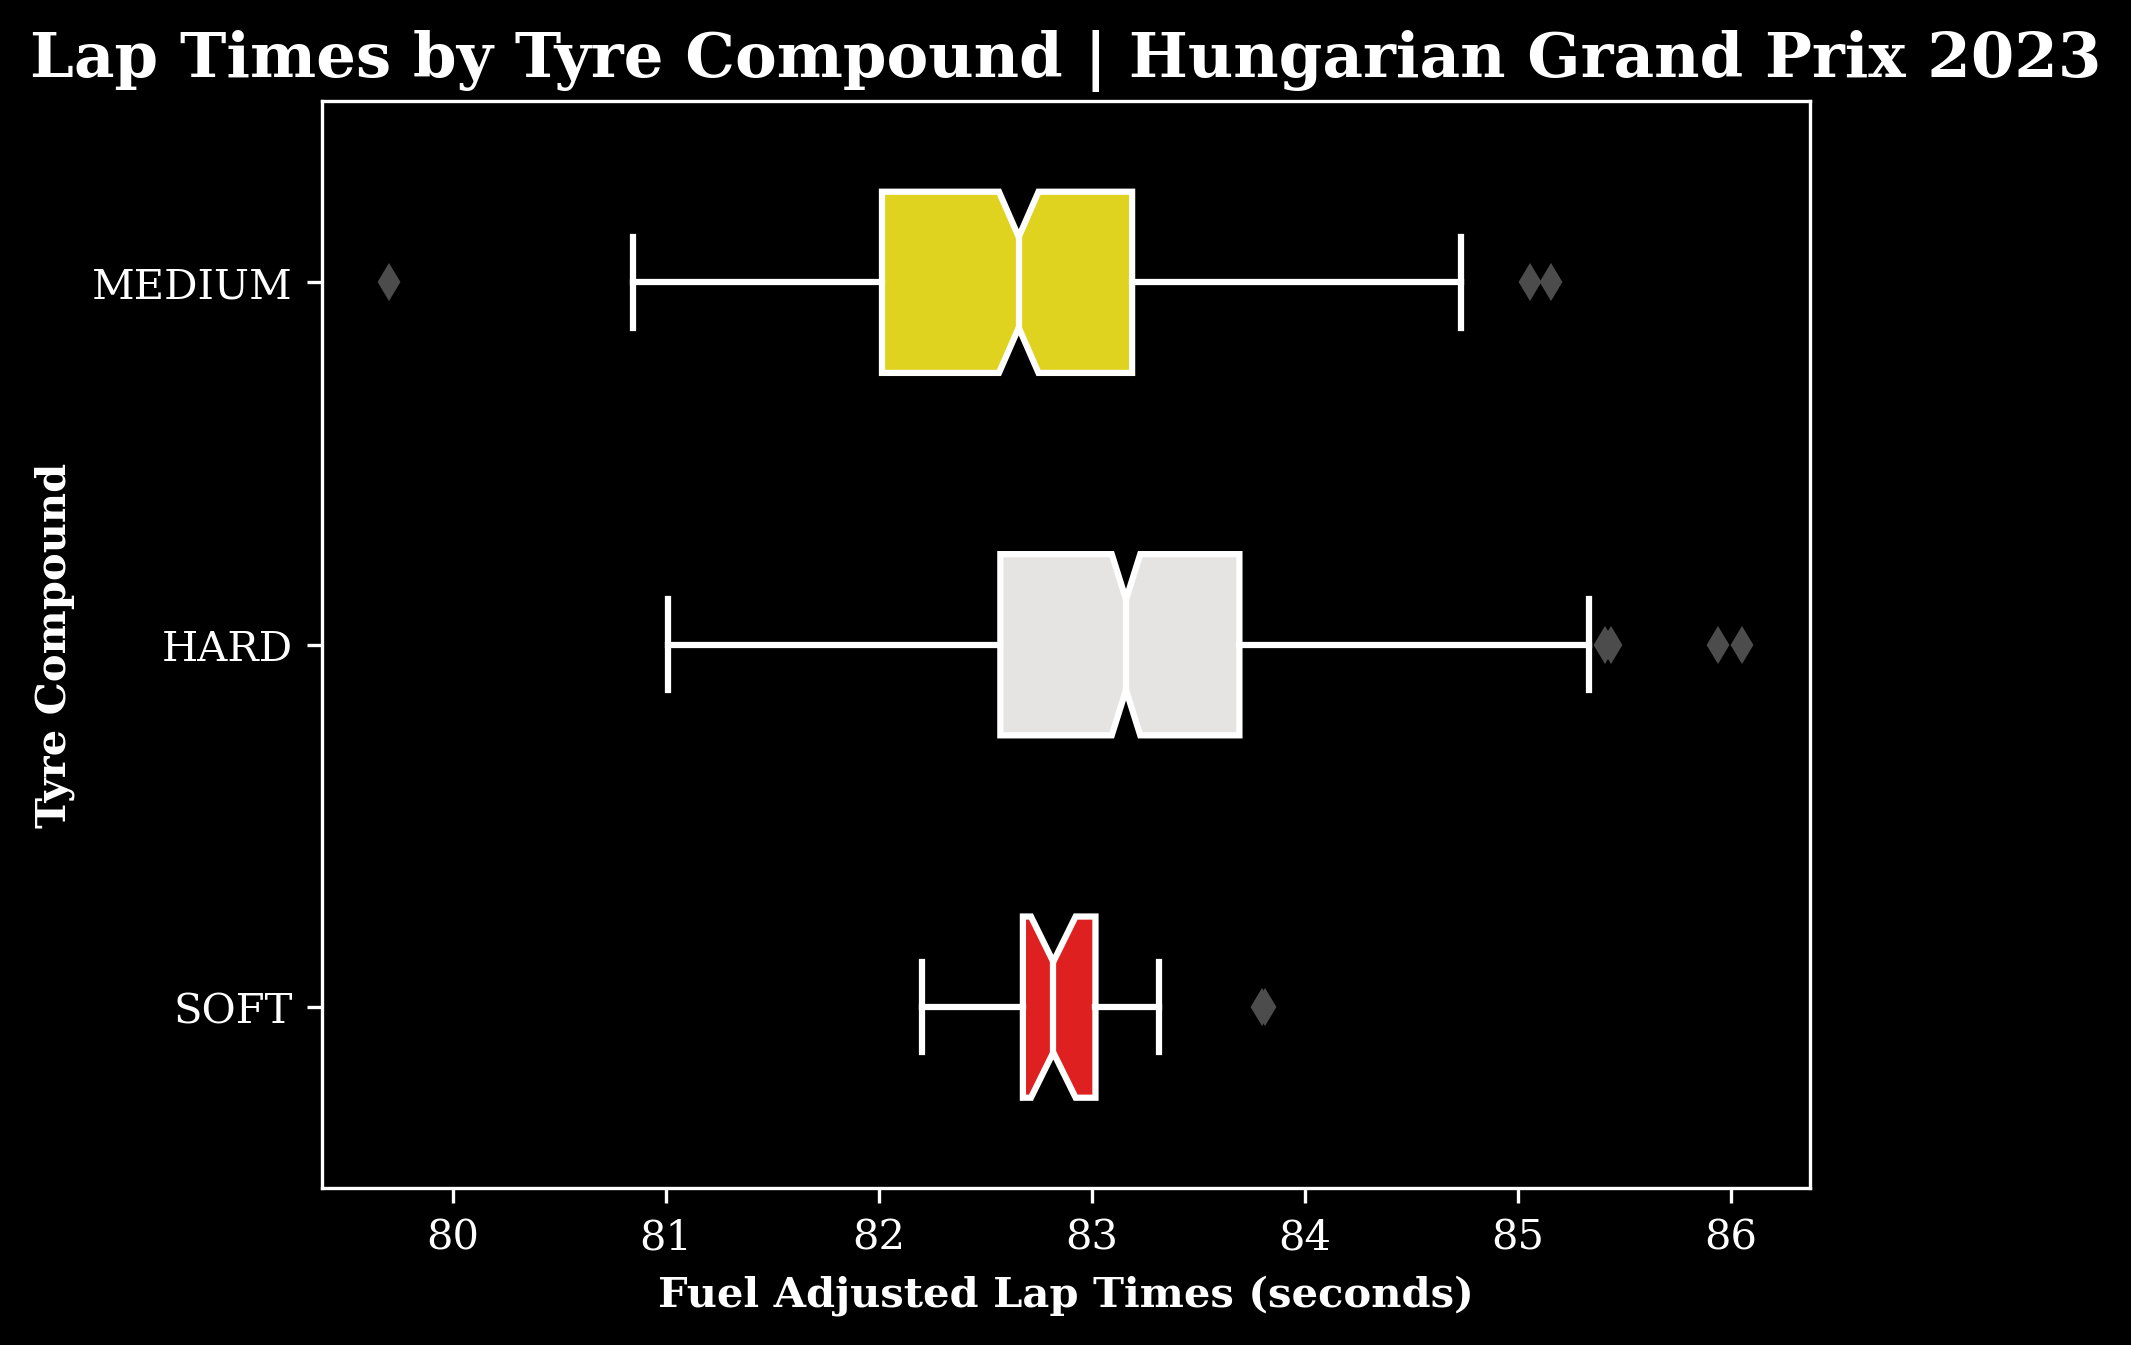

In [58]:
#box plot showing the relationship between the lap time and the compound
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')

PROPS = {
    'boxprops':{ 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

#making a dictionary for colors based off of the unique tyre compound
compound_color={'SOFT':'#FF0000','MEDIUM':'#FFEF00','HARD':'#E5E4E2','INTERMEDIATE':'#008000','WET':'#0000FF','UNKNOWN':'#000000'}

#change UNKNOW in the laps dataframe to SOFT
laps.loc[laps['Compound']=='UNKNOWN','Compound']='UNKNOWN'

#box plot to show distribution of lap times for each compound
sns.boxplot(x='LapTime_fuelCorrected',y='Compound',data=laps,palette=compound_color,width=0.5,linewidth=1.5,notch=True,**PROPS)
plt.title(f'Lap Times by Tyre Compound | {race.weekend.name} {race.weekend.year}', fontsize=15, fontweight='bold',color='White')
plt.xlabel('Fuel Adjusted Lap Times (seconds)', fontsize=10, fontweight='bold',color='white')
plt.ylabel('Tyre Compound', fontsize=10, fontweight='bold',color='White')
plt.savefig(f'F1Plots/Lap Times by Compound {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


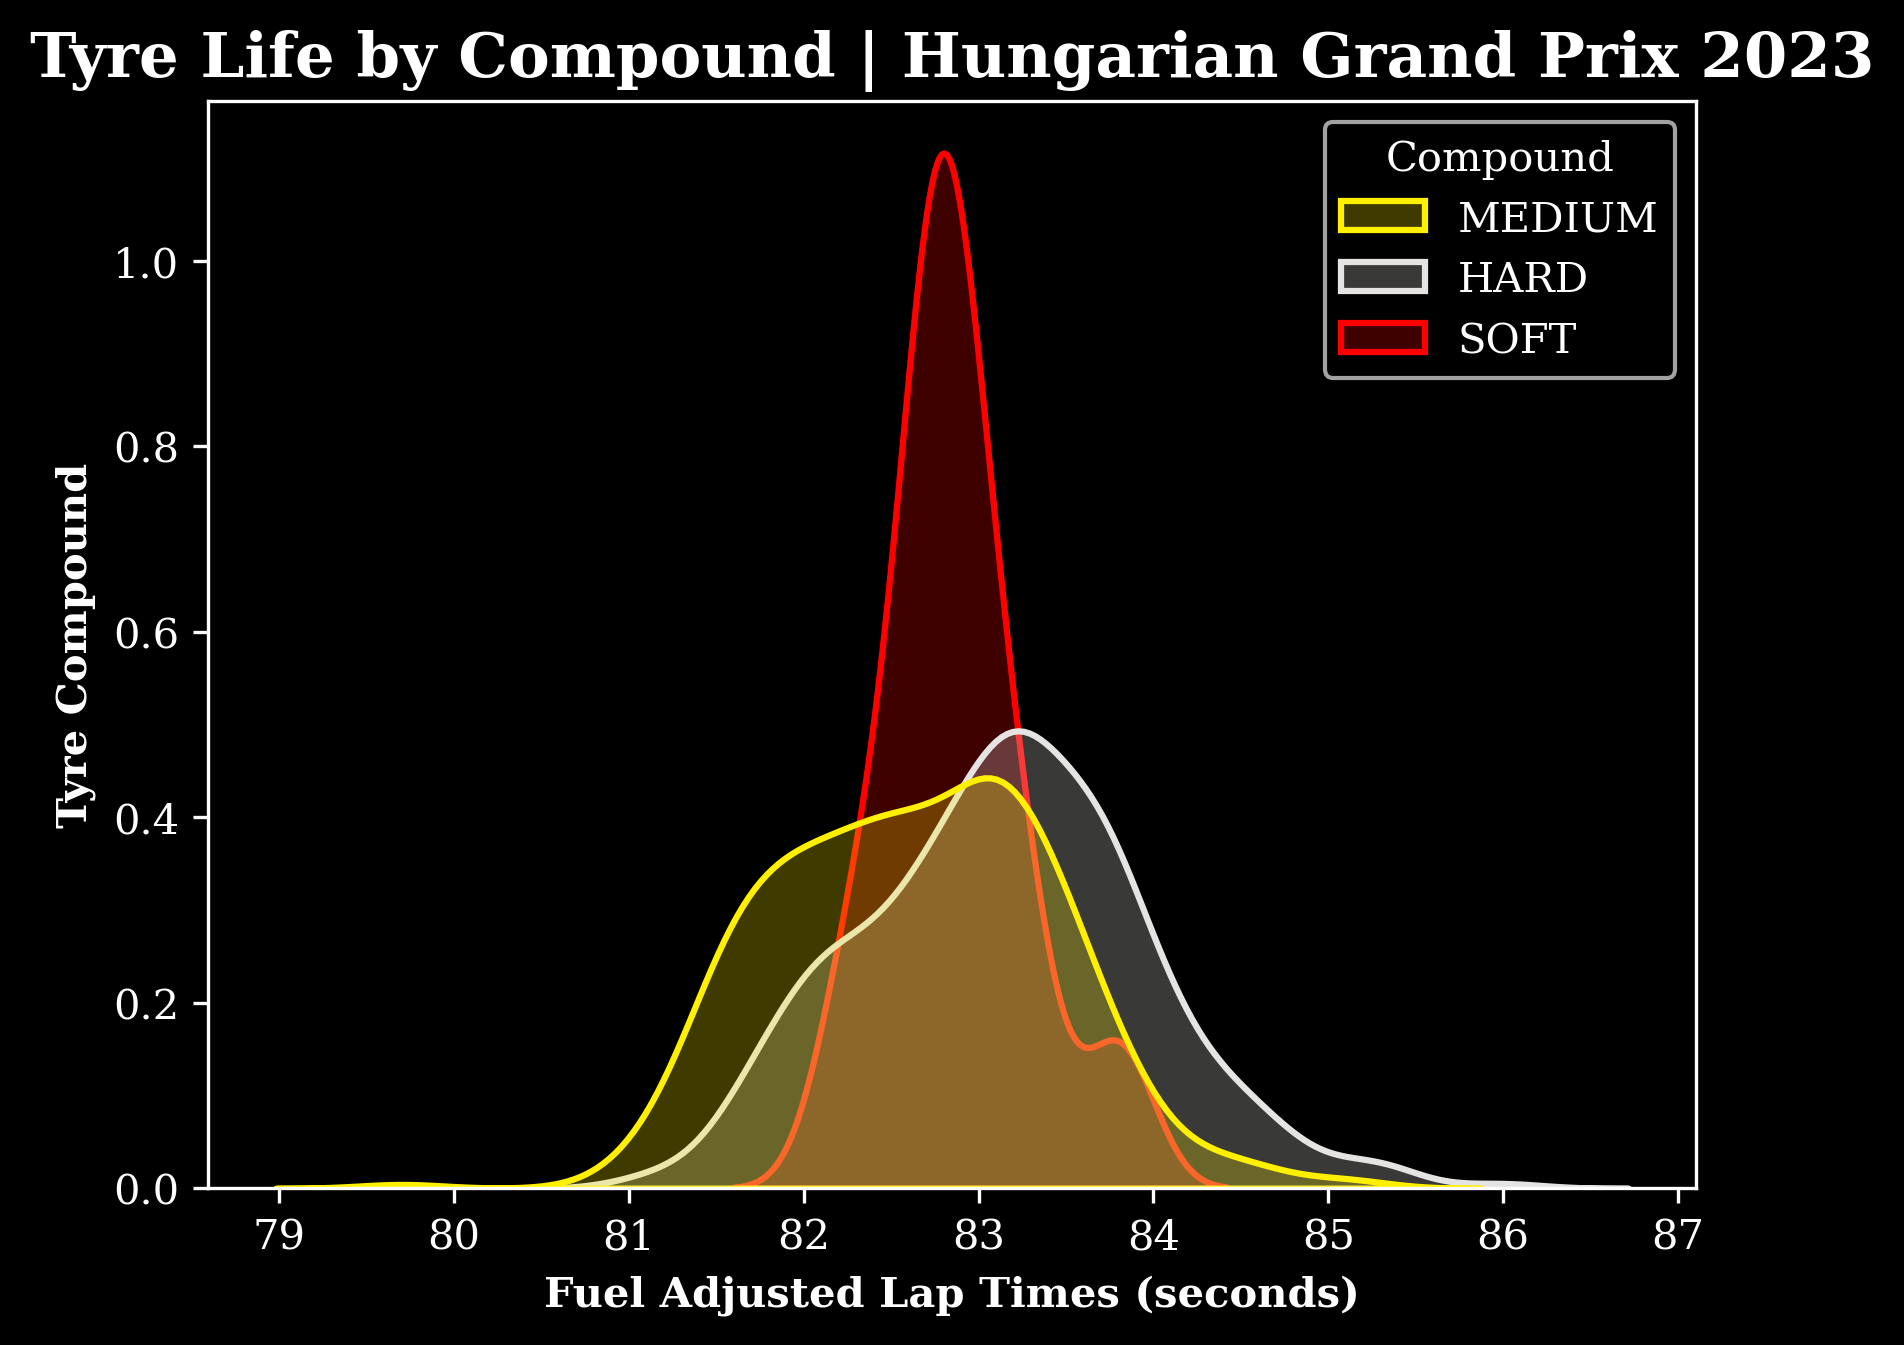

In [59]:
#kde plot showing the relationship between the lap time and the compound
plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')

PROPS = {
    'boxprops':{ 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

#making a dictionary for colors based off of the unique tyre compound
compound_color={'SOFT':'#FF0000','MEDIUM':'#FFEF00','HARD':'#E5E4E2','INTERMEDIATE':'#008000','WET':'#0000FF','UNKNOWN':'#000000'}

#change UNKNOW in the laps dataframe to SOFT
laps.loc[laps['Compound']=='UNKNOWN','Compound']='UNKNOWN'

#kde plot to show distribution of lap times for each compound
sns.kdeplot(data=laps,x='LapTime_fuelCorrected',hue='Compound',palette=compound_color,fill=True,common_norm=False,linewidth=1.5)
plt.title(f'Tyre Life by Compound | {race.weekend.name} {race.weekend.year}', fontsize=15, fontweight='bold',color='White')
plt.xlabel('Fuel Adjusted Lap Times (seconds)', fontsize=10, fontweight='bold',color='white')
plt.ylabel('Tyre Compound', fontsize=10, fontweight='bold',color='White')
plt.savefig(f'F1Plots/KDE by Compound {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


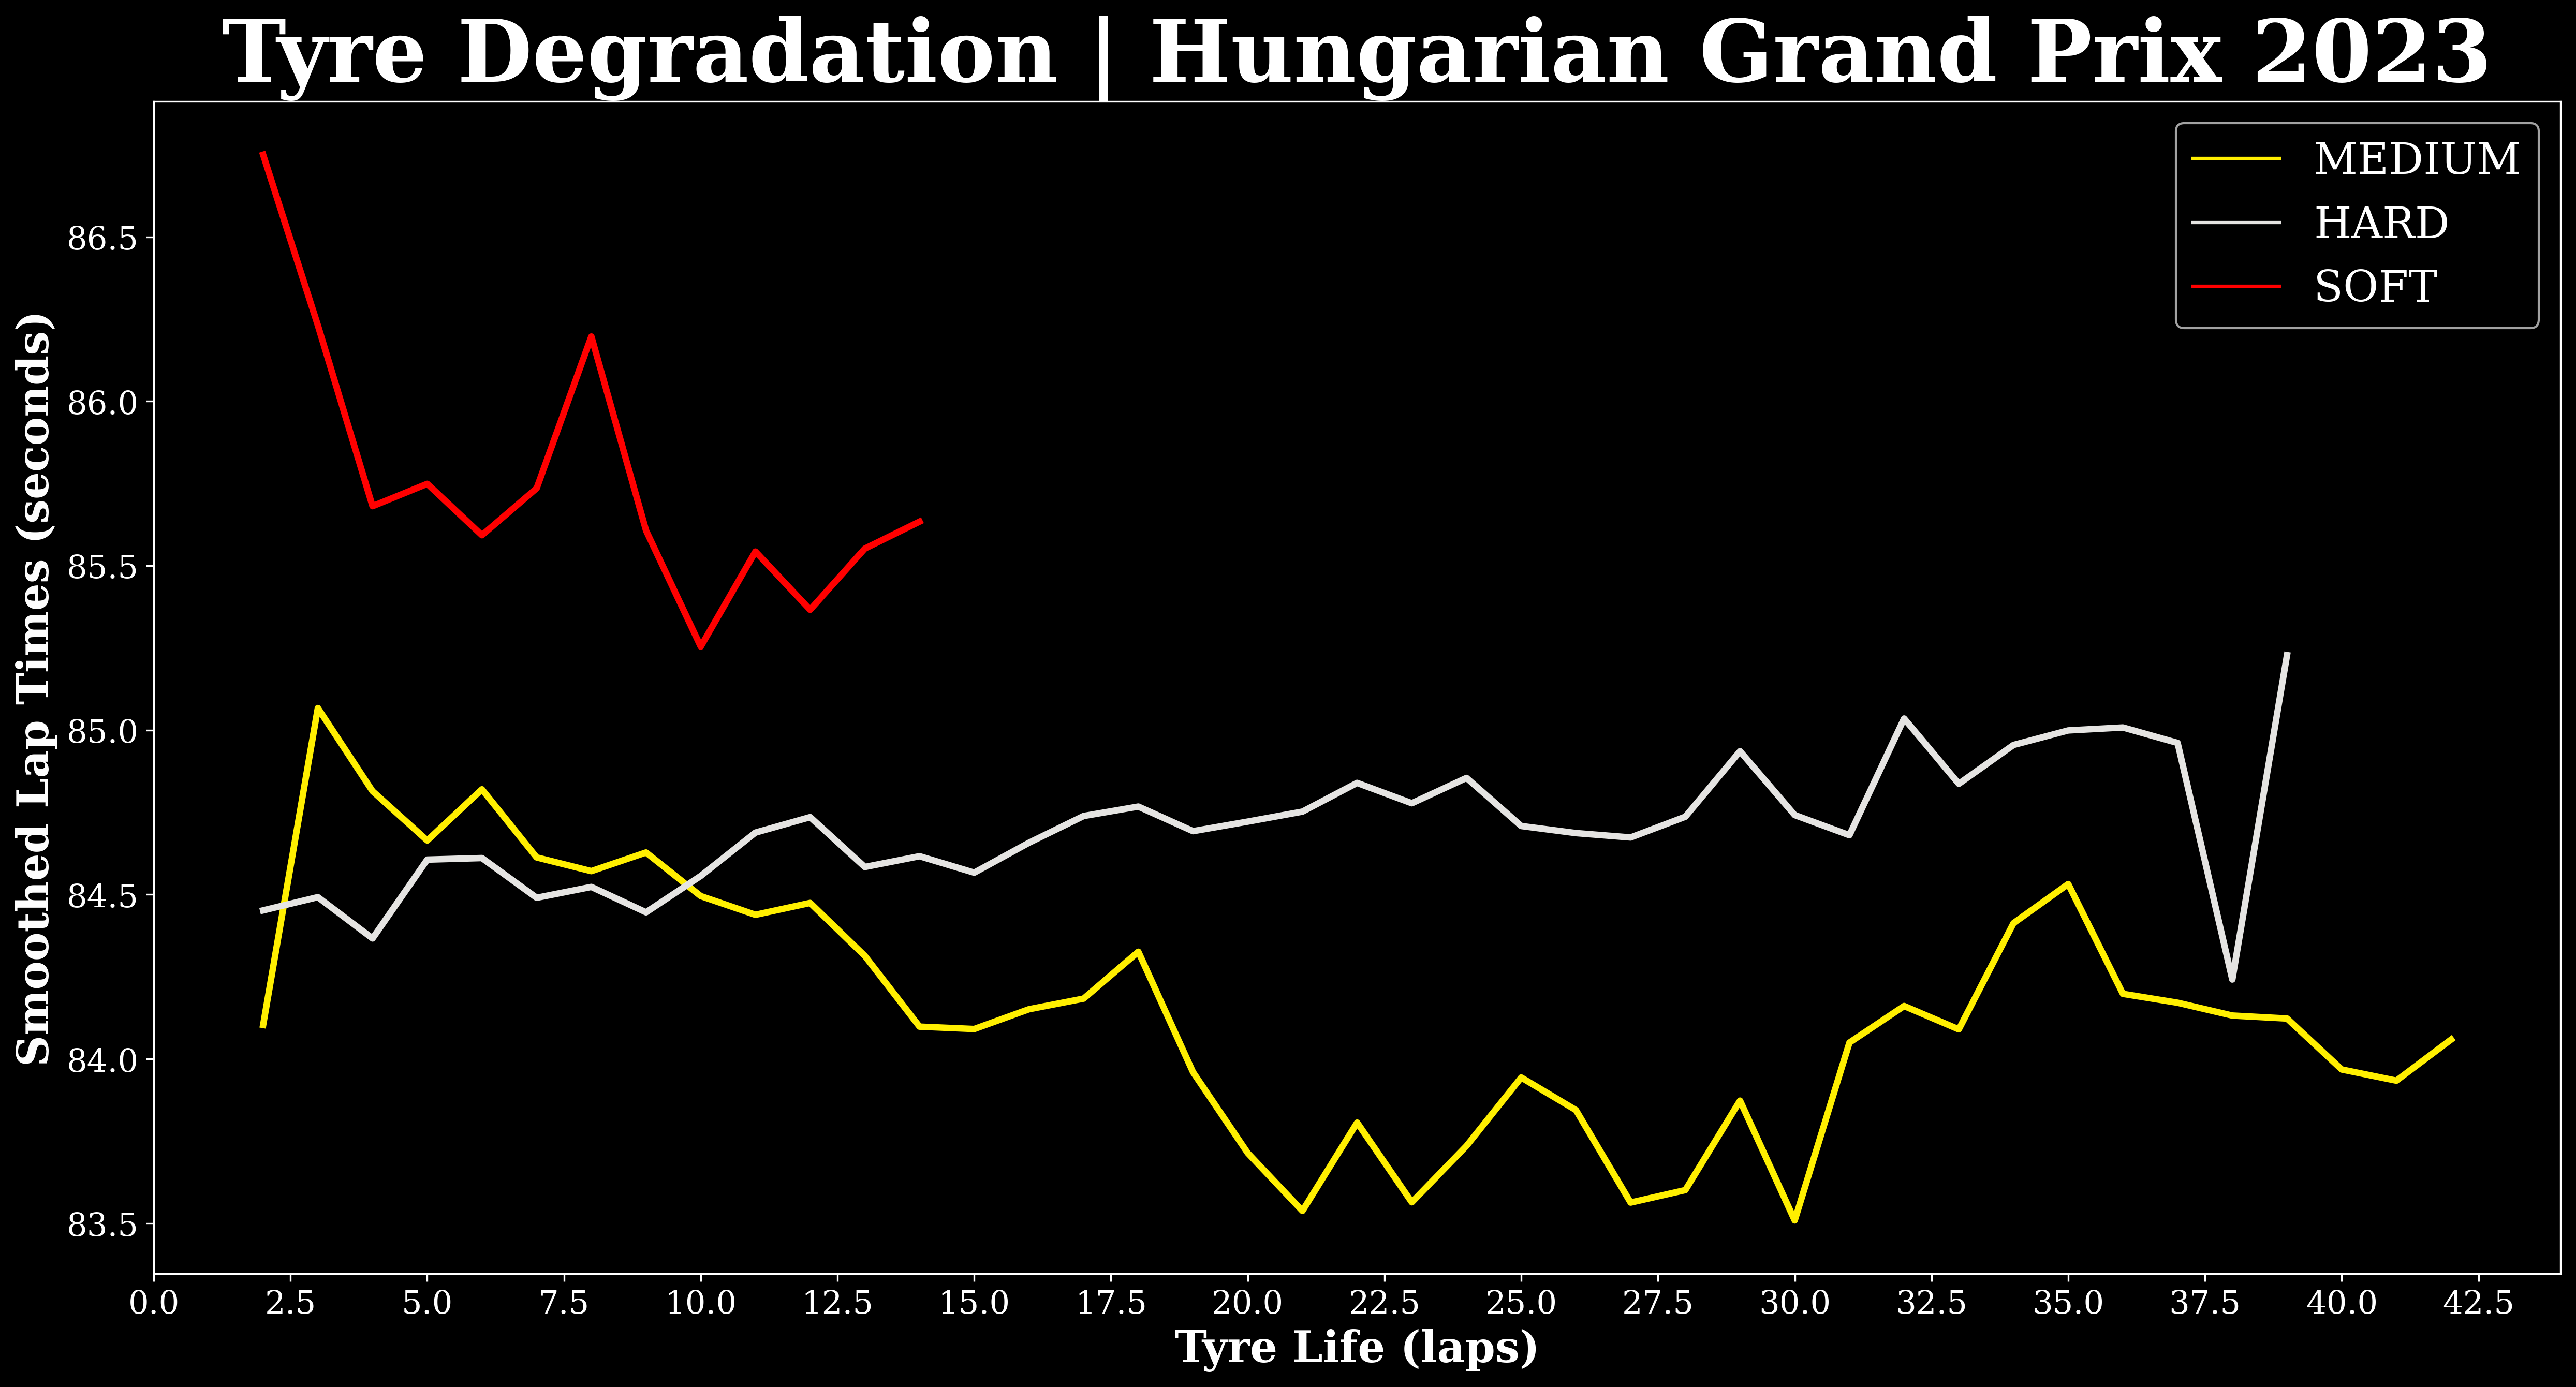

In [60]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300
#line plot showing LapTime_seconds on y axis and TyreLife on the x axis
sns.lineplot(data=laps,x='TyreLife',y='LapTime_seconds',hue='Compound',palette=compound_color,linewidth=3,err_style=None)
plt.title(f'Tyre Degradation | {race.weekend.name} {race.weekend.year}', fontsize=40, fontweight='bold',color='White')
plt.xlabel('Tyre Life (laps)', fontsize=20, fontweight='bold',color='white')
plt.ylabel('Smoothed Lap Times (seconds)', fontsize=20, fontweight='bold',color='White')
plt.legend(loc=1, prop={'size': 20})
plt.tick_params(labelsize=15)
plt.locator_params('x',nbins = 20)
plt.savefig(f'F1Plots/TyreDeg {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


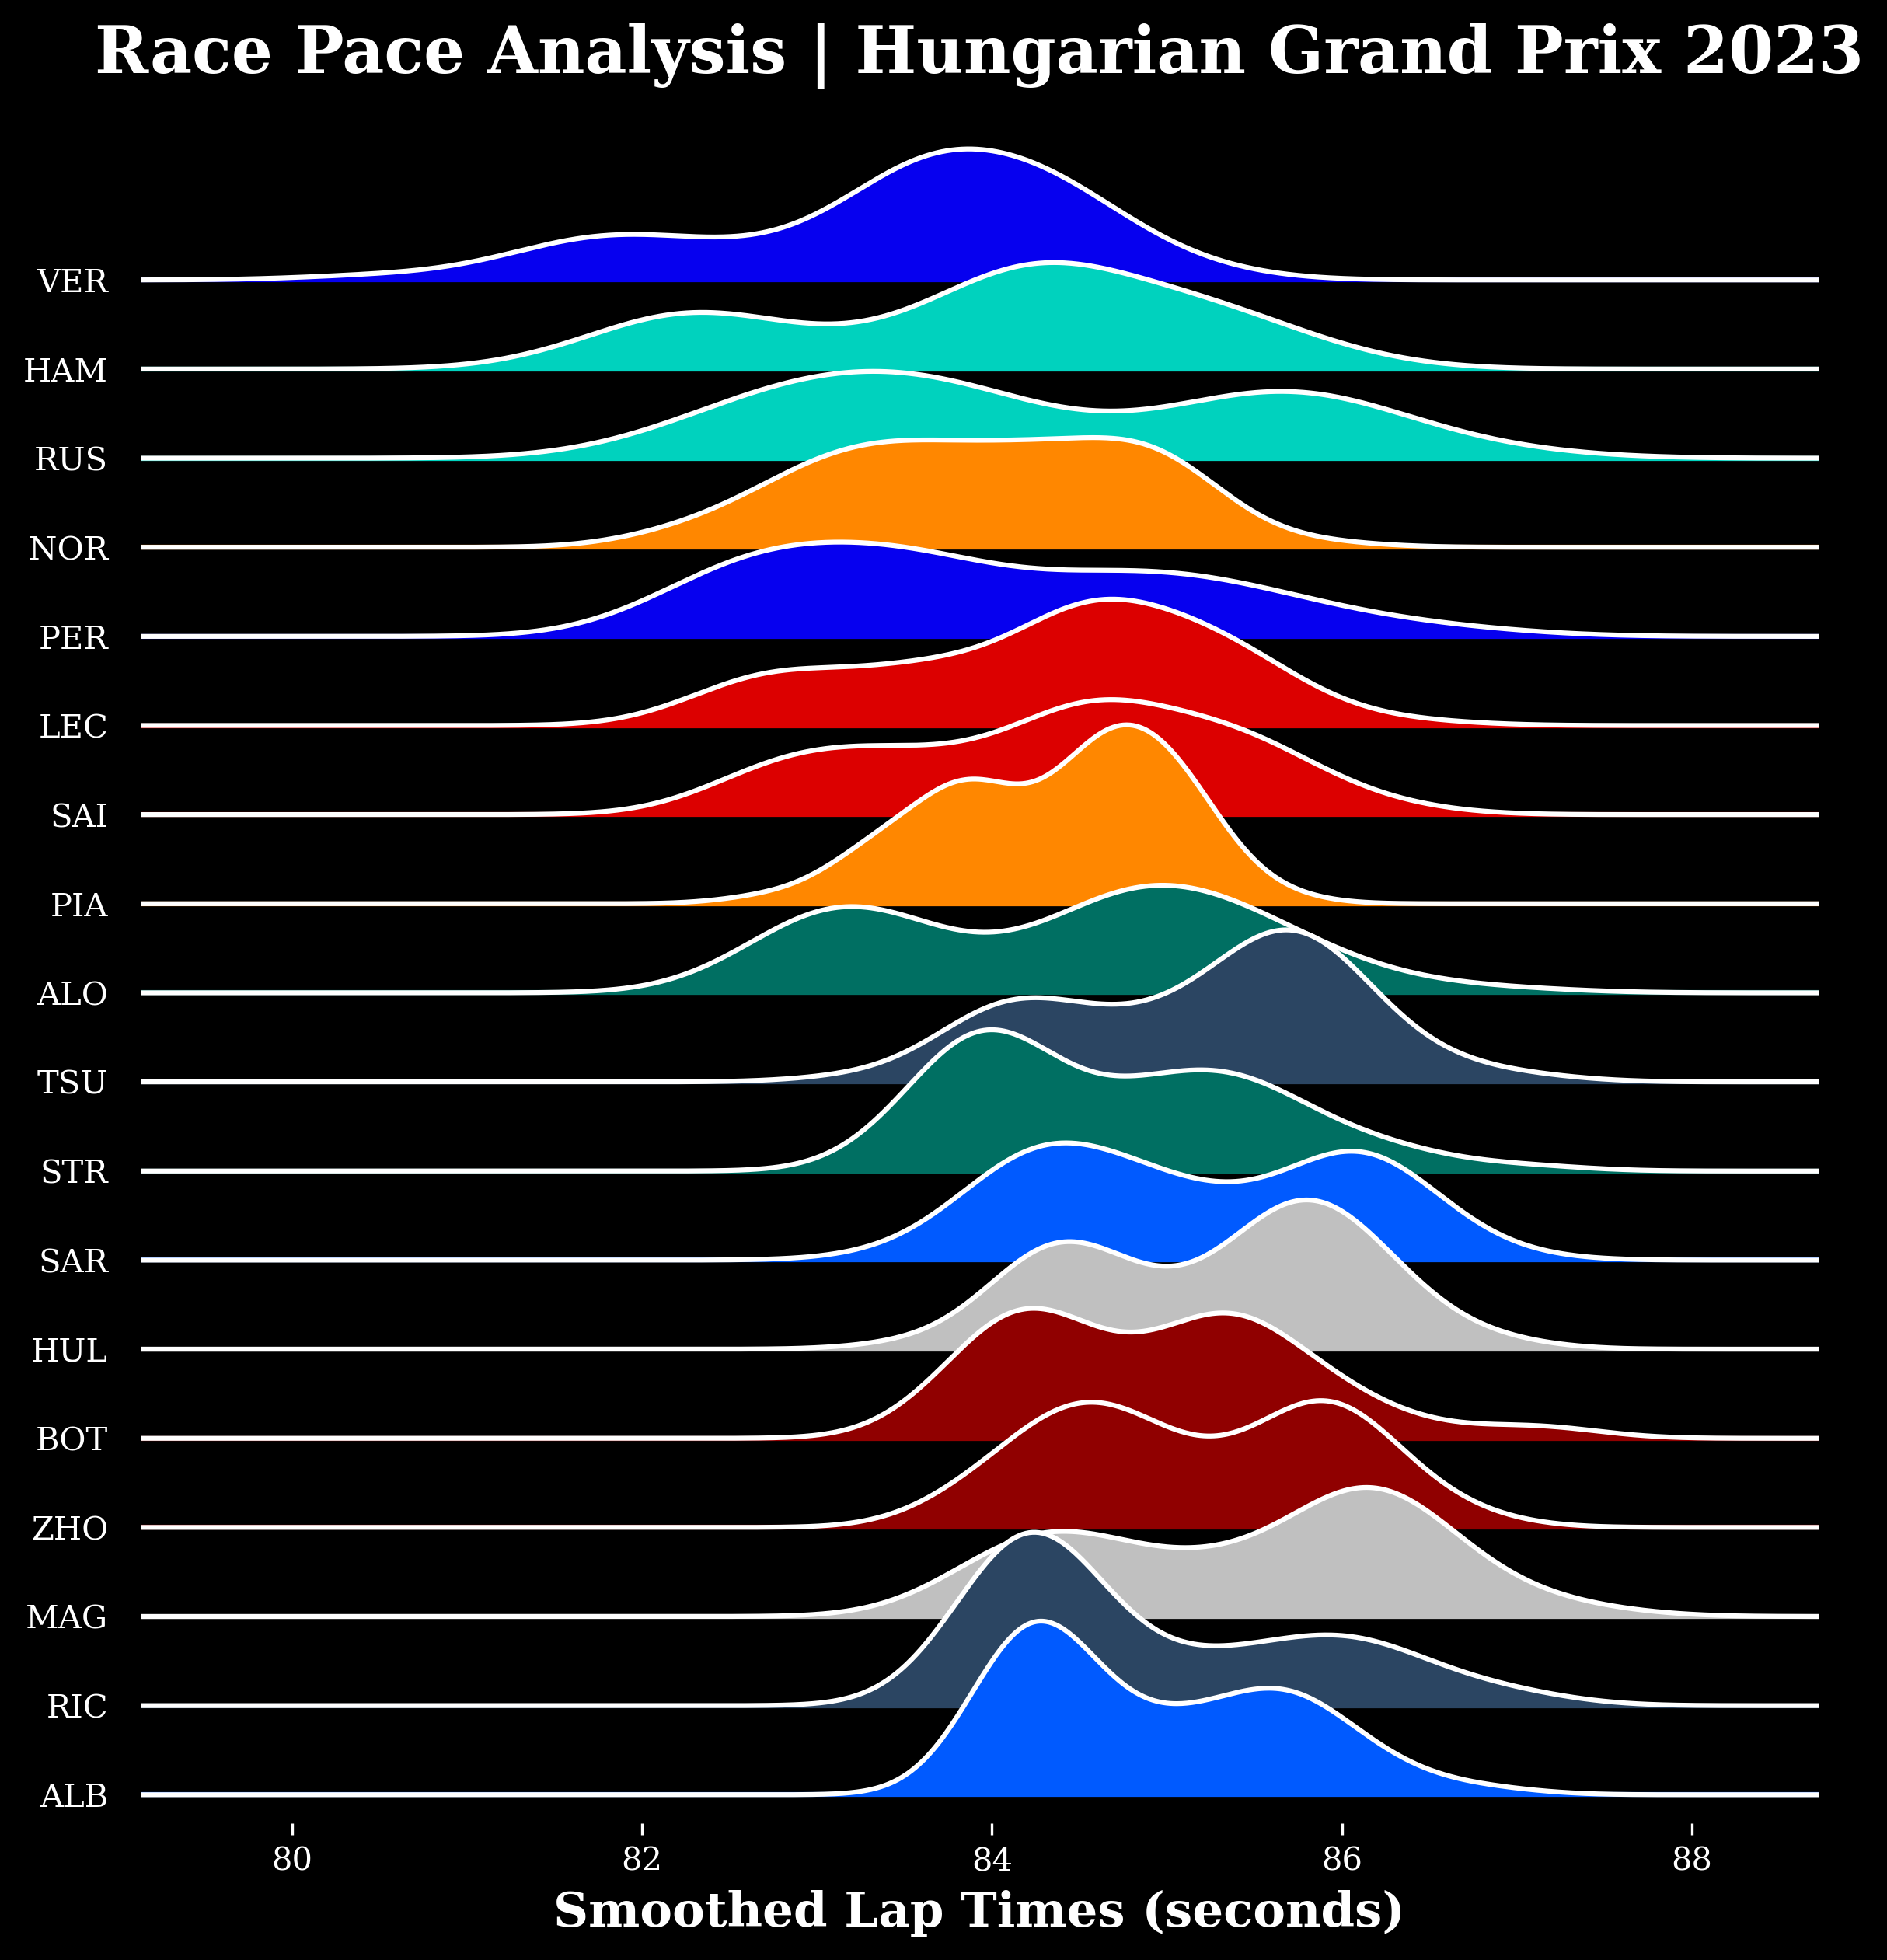

In [61]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']= [8,8]
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')

driver_color_ref=['#005aff','#0090ff','#900000','#2b4562','#00d2be','#005aff','#dc0000','silver','silver','#ff8700',
'#0090ff','#0600ef','#ff8700','#00d2be','#dc0000','#006f62','#2b4562','#0600ef','#006f62','#900000']

#setting Driver names as variables to their Driver color
alb_color=driver_color_ref[0]
gas_color=driver_color_ref[1]
bot_color=driver_color_ref[2]
ric_color=driver_color_ref[3]
ham_color=driver_color_ref[4]
sar_color=driver_color_ref[5]
lec_color=driver_color_ref[6]
mag_color=driver_color_ref[7]
hul_color=driver_color_ref[8]
nor_color=driver_color_ref[9]
oco_color=driver_color_ref[10]
per_color=driver_color_ref[11]
pia_color=driver_color_ref[12]
rus_color=driver_color_ref[13]
sai_color=driver_color_ref[14]
str_color=driver_color_ref[15]
tsu_color=driver_color_ref[16]
ver_color=driver_color_ref[17]
alo_color=driver_color_ref[18]
zho_color=driver_color_ref[19]


#create a list with the drivers colors
driver_color_ref_pal=[alb_color,gas_color,bot_color,ric_color,gas_color,ham_color,sar_color,lec_color,mag_color,
hul_color,nor_color,oco_color,per_color,pia_color,rus_color,sai_color,str_color,tsu_color,ver_color,alo_color,zho_color]

#create a dictionary with the drivers colors
driver_color_ref_dict={'ALB':alb_color,'ALO':alo_color,'BOT':bot_color,'RIC':ric_color,'GAS':gas_color,'HAM':ham_color,'SAR':sar_color, 'LEC':lec_color, 'MAG':mag_color, 'HUL':hul_color, 'NOR':nor_color,
 'OCO':oco_color, 'PER':per_color, 'PIA':pia_color, 'RUS':rus_color, 'SAI':sai_color, 'STR':str_color, 'TSU':tsu_color, 'VER':ver_color, 'ALO':alo_color, 'ZHO':zho_color}

#match the drivers in the laps dataframe to the drivers in the driver_color_ref_dict
laps['Driver_Color']=laps['Driver'].map(driver_color_ref_dict)

#Sort the laps dataframe by LapTime_seconds and then group by Driver
laps_sorted=laps.sort_values(by='LapTime_seconds')
laps_grouped=laps_sorted.groupby('Driver',sort=False)

#making dataframe that holds drivers sorted and their Driver color
laps_color=laps_sorted.loc[:, ['Driver', 'Driver_Color']]

#for loop that selects a unique Driver in laps color and then puts their Driver_Color in a list
driver_color_list=[]
for i in laps_color['Driver'].unique():
    driver_color_list.append(laps_color.loc[laps_color['Driver']==i,'Driver_Color'].values[0])

#create a joyplot plot for LapTime_seconds using laps_grouped and the colors from Driver_Color
from joypy import joyplot
joyplot(laps_grouped, by='Driver', column='LapTime_seconds',linecolor='white',color=driver_color_list,overlap=.85)
plt.title(f'Race Pace Analysis | {race.weekend.name} {race.weekend.year}' , fontsize=20, fontweight='bold',color='white')
plt.xlabel('Smoothed Lap Times (seconds)', fontsize=15, fontweight='bold',color='white')
plt.savefig(f'F1Plots/Lap Time Distributions by Driver {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

In [62]:
'''
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']= [4,4]
plt.rcParams['font.family'] = 'serif'

from matplotlib.ticker import FormatStrFormatter

drivers = pd.unique(session.laps['Driver'])

list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)

fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()
ax.xaxis.offsetText.set_visible(False)
ax.set_xlabel('Lap Time Delta (seconds)', fontsize=10, fontweight='bold',color='white')


# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{session.event['EventName']} {session.name} {session.event.year}\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})",fontweight='bold',fontsize=15,color='white')

plt.savefig(f'f1plots\Fastest Lap {session.event.name} {session.event.year}.png',bbox_inches='tight')

plt.show()
'''

'\nplt.rcParams[\'figure.dpi\'] = 300\nplt.rcParams[\'figure.figsize\']= [4,4]\nplt.rcParams[\'font.family\'] = \'serif\'\n\nfrom matplotlib.ticker import FormatStrFormatter\n\ndrivers = pd.unique(session.laps[\'Driver\'])\n\nlist_fastest_laps = list()\nfor drv in drivers:\n    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()\n    list_fastest_laps.append(drvs_fastest_lap)\nfastest_laps = Laps(list_fastest_laps).sort_values(by=\'LapTime\').reset_index(drop=True)\n\npole_lap = fastest_laps.pick_fastest()\nfastest_laps[\'LapTimeDelta\'] = fastest_laps[\'LapTime\'] - pole_lap[\'LapTime\']\n\nteam_colors = list()\nfor index, lap in fastest_laps.iterlaps():\n    color = ff1.plotting.team_color(lap[\'Team\'])\n    team_colors.append(color)\n\nfig, ax = plt.subplots()\nax.barh(fastest_laps.index, fastest_laps[\'LapTimeDelta\'],\n        color=team_colors, edgecolor=\'grey\')\nax.set_yticks(fastest_laps.index)\nax.set_yticklabels(fastest_laps[\'Driver\'])\n\n# show fastest at th

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


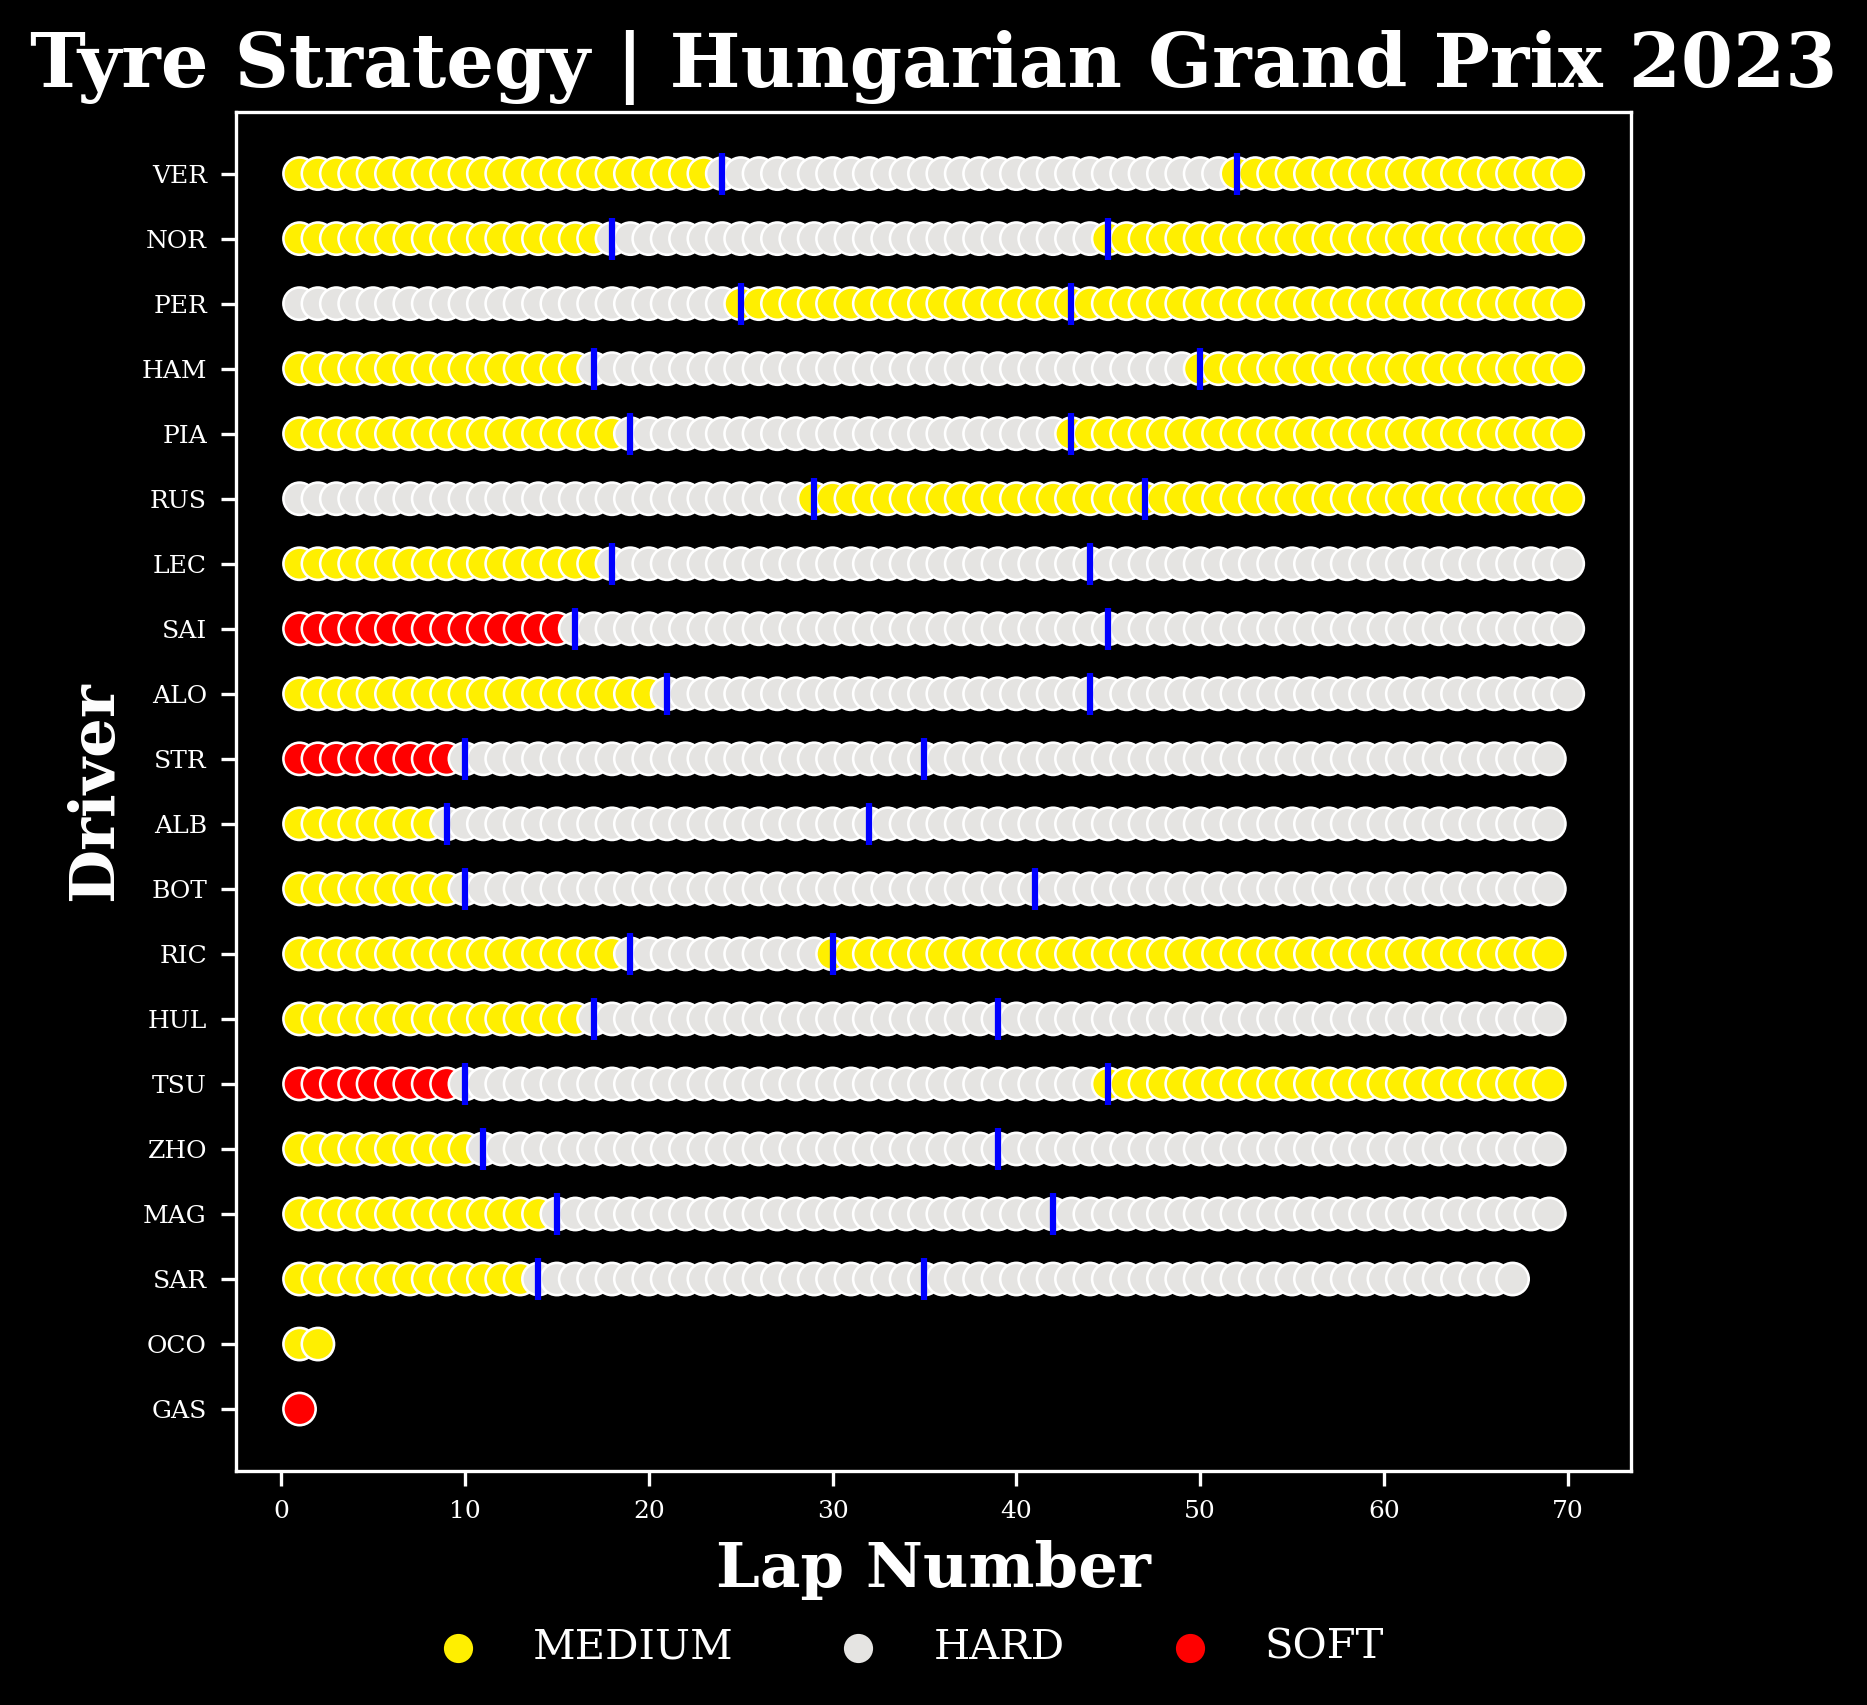

In [63]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize']= [6,6]
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')

#making a dictionary for colors based off of the unique tyre compound
compound_color={'SOFT':'#FF0000','MEDIUM':'#FFEF00','HARD':'#E5E4E2','INTERMEDIATE':'#008000','WET':'#0000FF','UNKNOWN':'#000000'}

#change UNKNOW in the laps dataframe to SOFT
laps_uncleaned.loc[laps_uncleaned['Compound']=='UNKNOWN','Compound']='SOFT'

#make a new column called IsPitStop and set it to True any time the Driver changes Stint number except for the first lap
laps_uncleaned['IsPitStop']=laps_uncleaned['Stint'].diff()!=0
laps_uncleaned.loc[laps_uncleaned['LapNumber']==1,'IsPitStop']=False

#change LapNumber 1 to False
laps_uncleaned.loc[laps_uncleaned['LapNumber']==1,'IsPitStop']=False

#change RUS Compound in LapNumber 30 and 29 to MEDIUM
laps_uncleaned.loc[(laps_uncleaned['Driver']=='RUS')&(laps_uncleaned['LapNumber']==30),'Compound']='MEDIUM'
laps_uncleaned.loc[(laps_uncleaned['Driver']=='RUS')&(laps_uncleaned['LapNumber']==29),'Compound']='MEDIUM'

#show what Compound a Driver is using during the LapNumber
laps_uncleaned['Compound_Color']=laps_uncleaned['Compound'].map(compound_color)

#show scatter plot of LapNumber and Compound by Driver and show where the pit stops are
sns.scatterplot(x='LapNumber',y='Driver',data=laps_uncleaned,hue='Compound',palette=compound_color,s=60,marker='o')
#put a small vertical line at the pit stops on just the row of the Driver
sns.scatterplot(x='LapNumber',y='Driver',data=laps_uncleaned.loc[laps_uncleaned['IsPitStop']==True],color='blue',s=100,marker='|',linewidth=1.5,)
plt.title(f'Tyre Strategy | {race.weekend.name} {race.weekend.year}' , fontsize=18, fontweight='bold',color='white')
plt.xlabel('Lap Number', fontsize=15, fontweight='bold',color='white')
plt.ylabel('Driver', fontsize=15, fontweight='bold',color='white')
plt.tick_params(labelsize=6, color='white')

#normal bbox to anchor is (.7,0)
plt.legend(bbox_to_anchor=(.15,0), loc="lower center", 
           bbox_transform=fig.transFigure, ncol=laps_uncleaned['Compound'].nunique(),frameon=False,fontsize=10)
plt.savefig(f'F1Plots/Tyre Strategy by Driver {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.
legend      WARNING 	No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


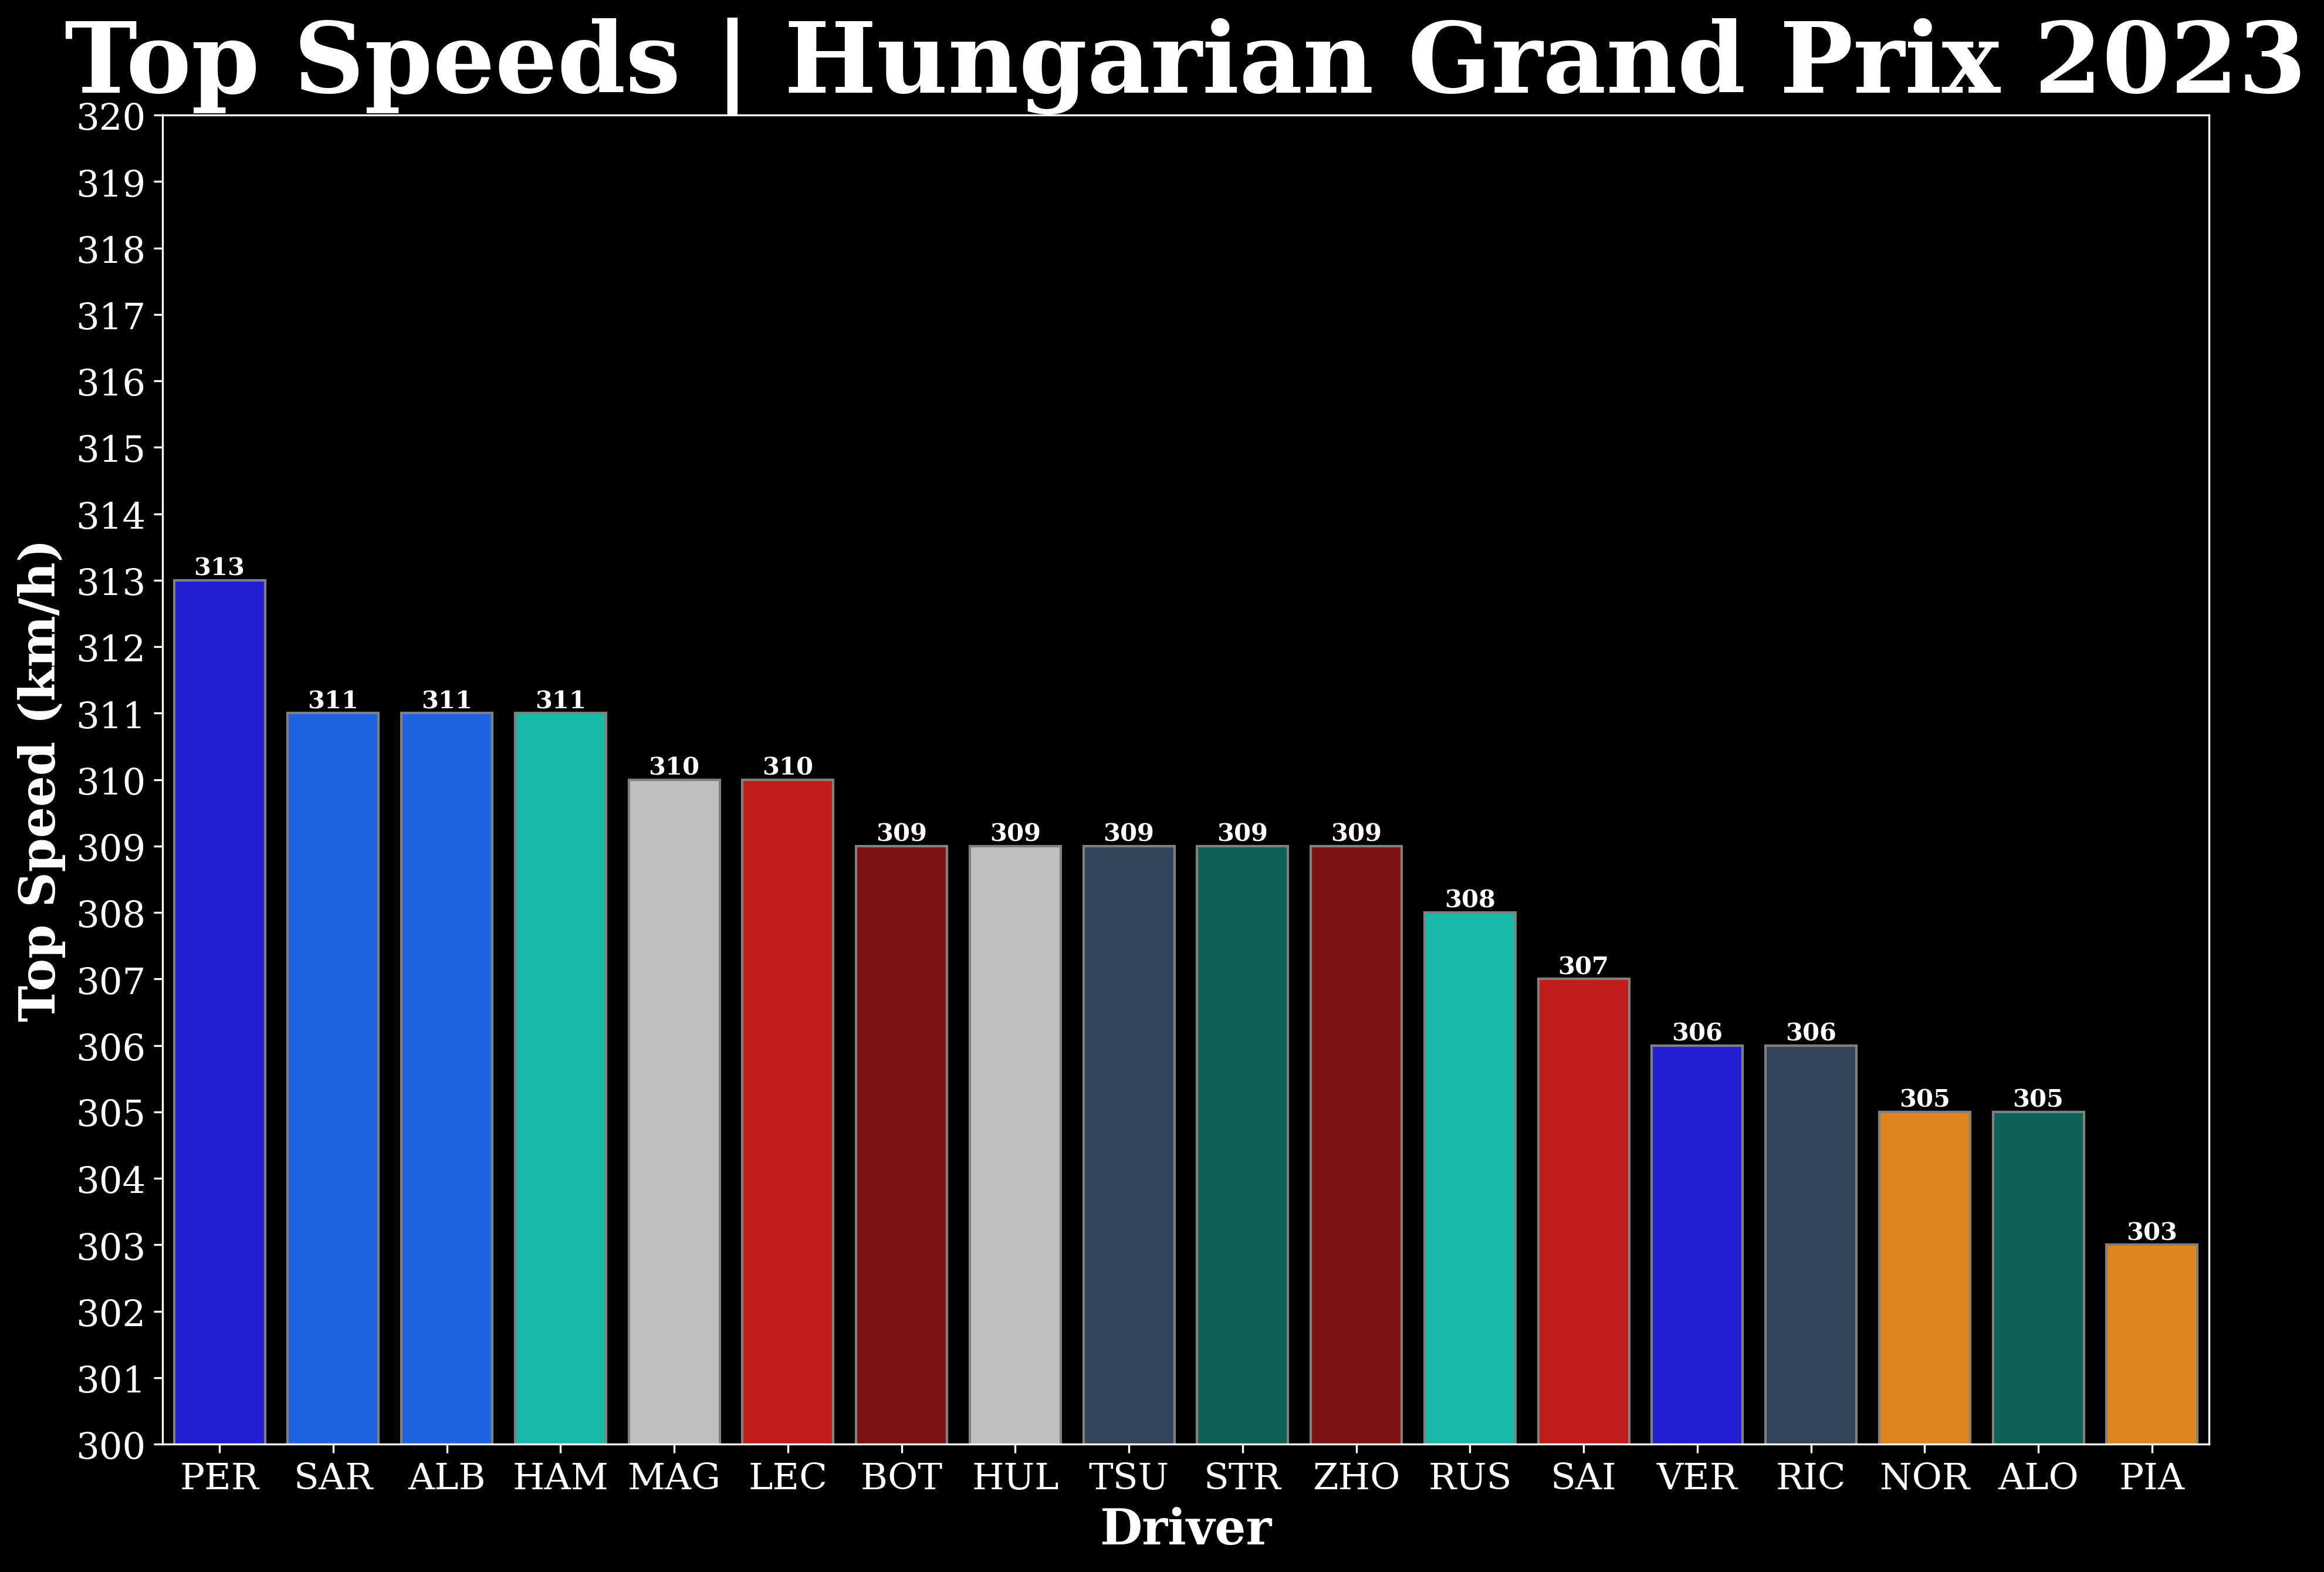

In [64]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300

lapsbyspeed = laps.sort_values(['SpeedST'], ascending=False).reset_index(drop=True)

ax=sns.barplot(data=lapsbyspeed,x='Driver',y='SpeedST',
palette=driver_color_ref_dict,ci=None,edgecolor='grey',estimator=max)
plt.ylim(300,320)
ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge',color='white',fontweight='bold')
plt.title(f'Top Speeds | {race.weekend.name} {race.weekend.year}', fontsize=40, fontweight='bold',color='White')
plt.xlabel('Driver', fontsize=20, fontweight='bold',color='white')
plt.ylabel('Top Speed (km/h)', fontsize=20, fontweight='bold',color='White')
plt.legend().remove()
plt.tick_params(labelsize=15)
plt.locator_params('y',nbins = 35)
plt.savefig(f'F1Plots/TopSpeeds {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


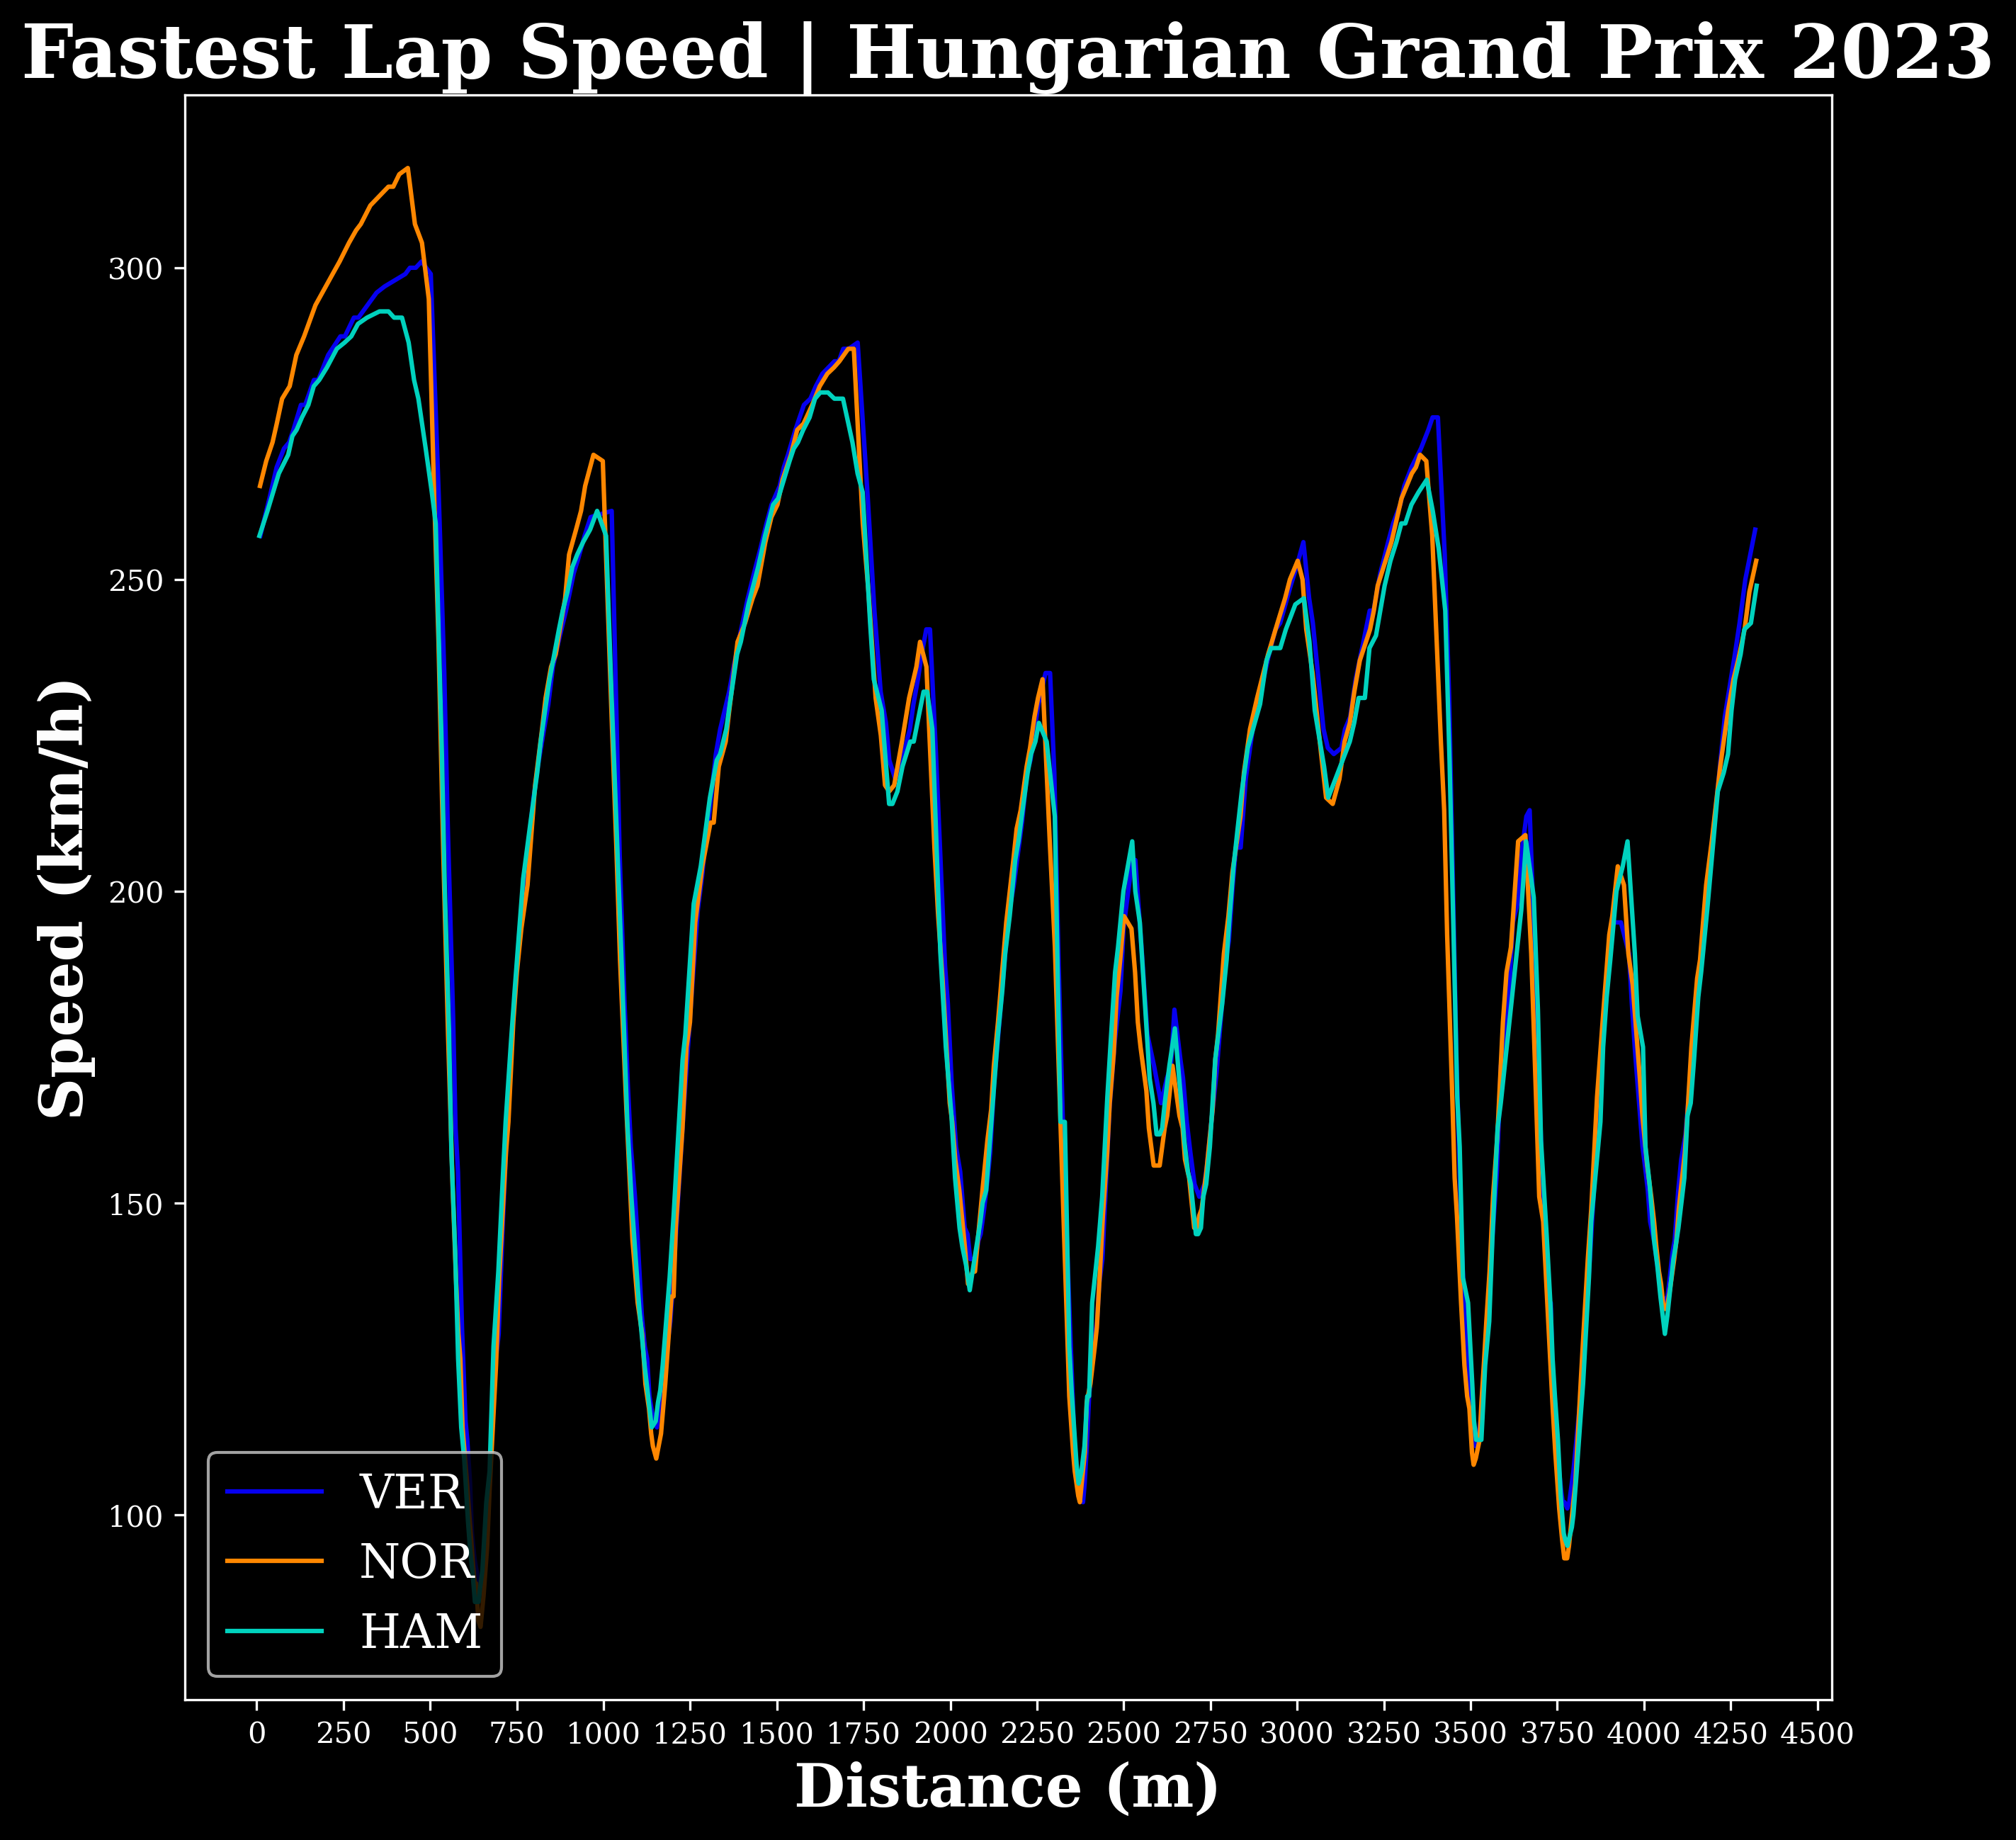

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


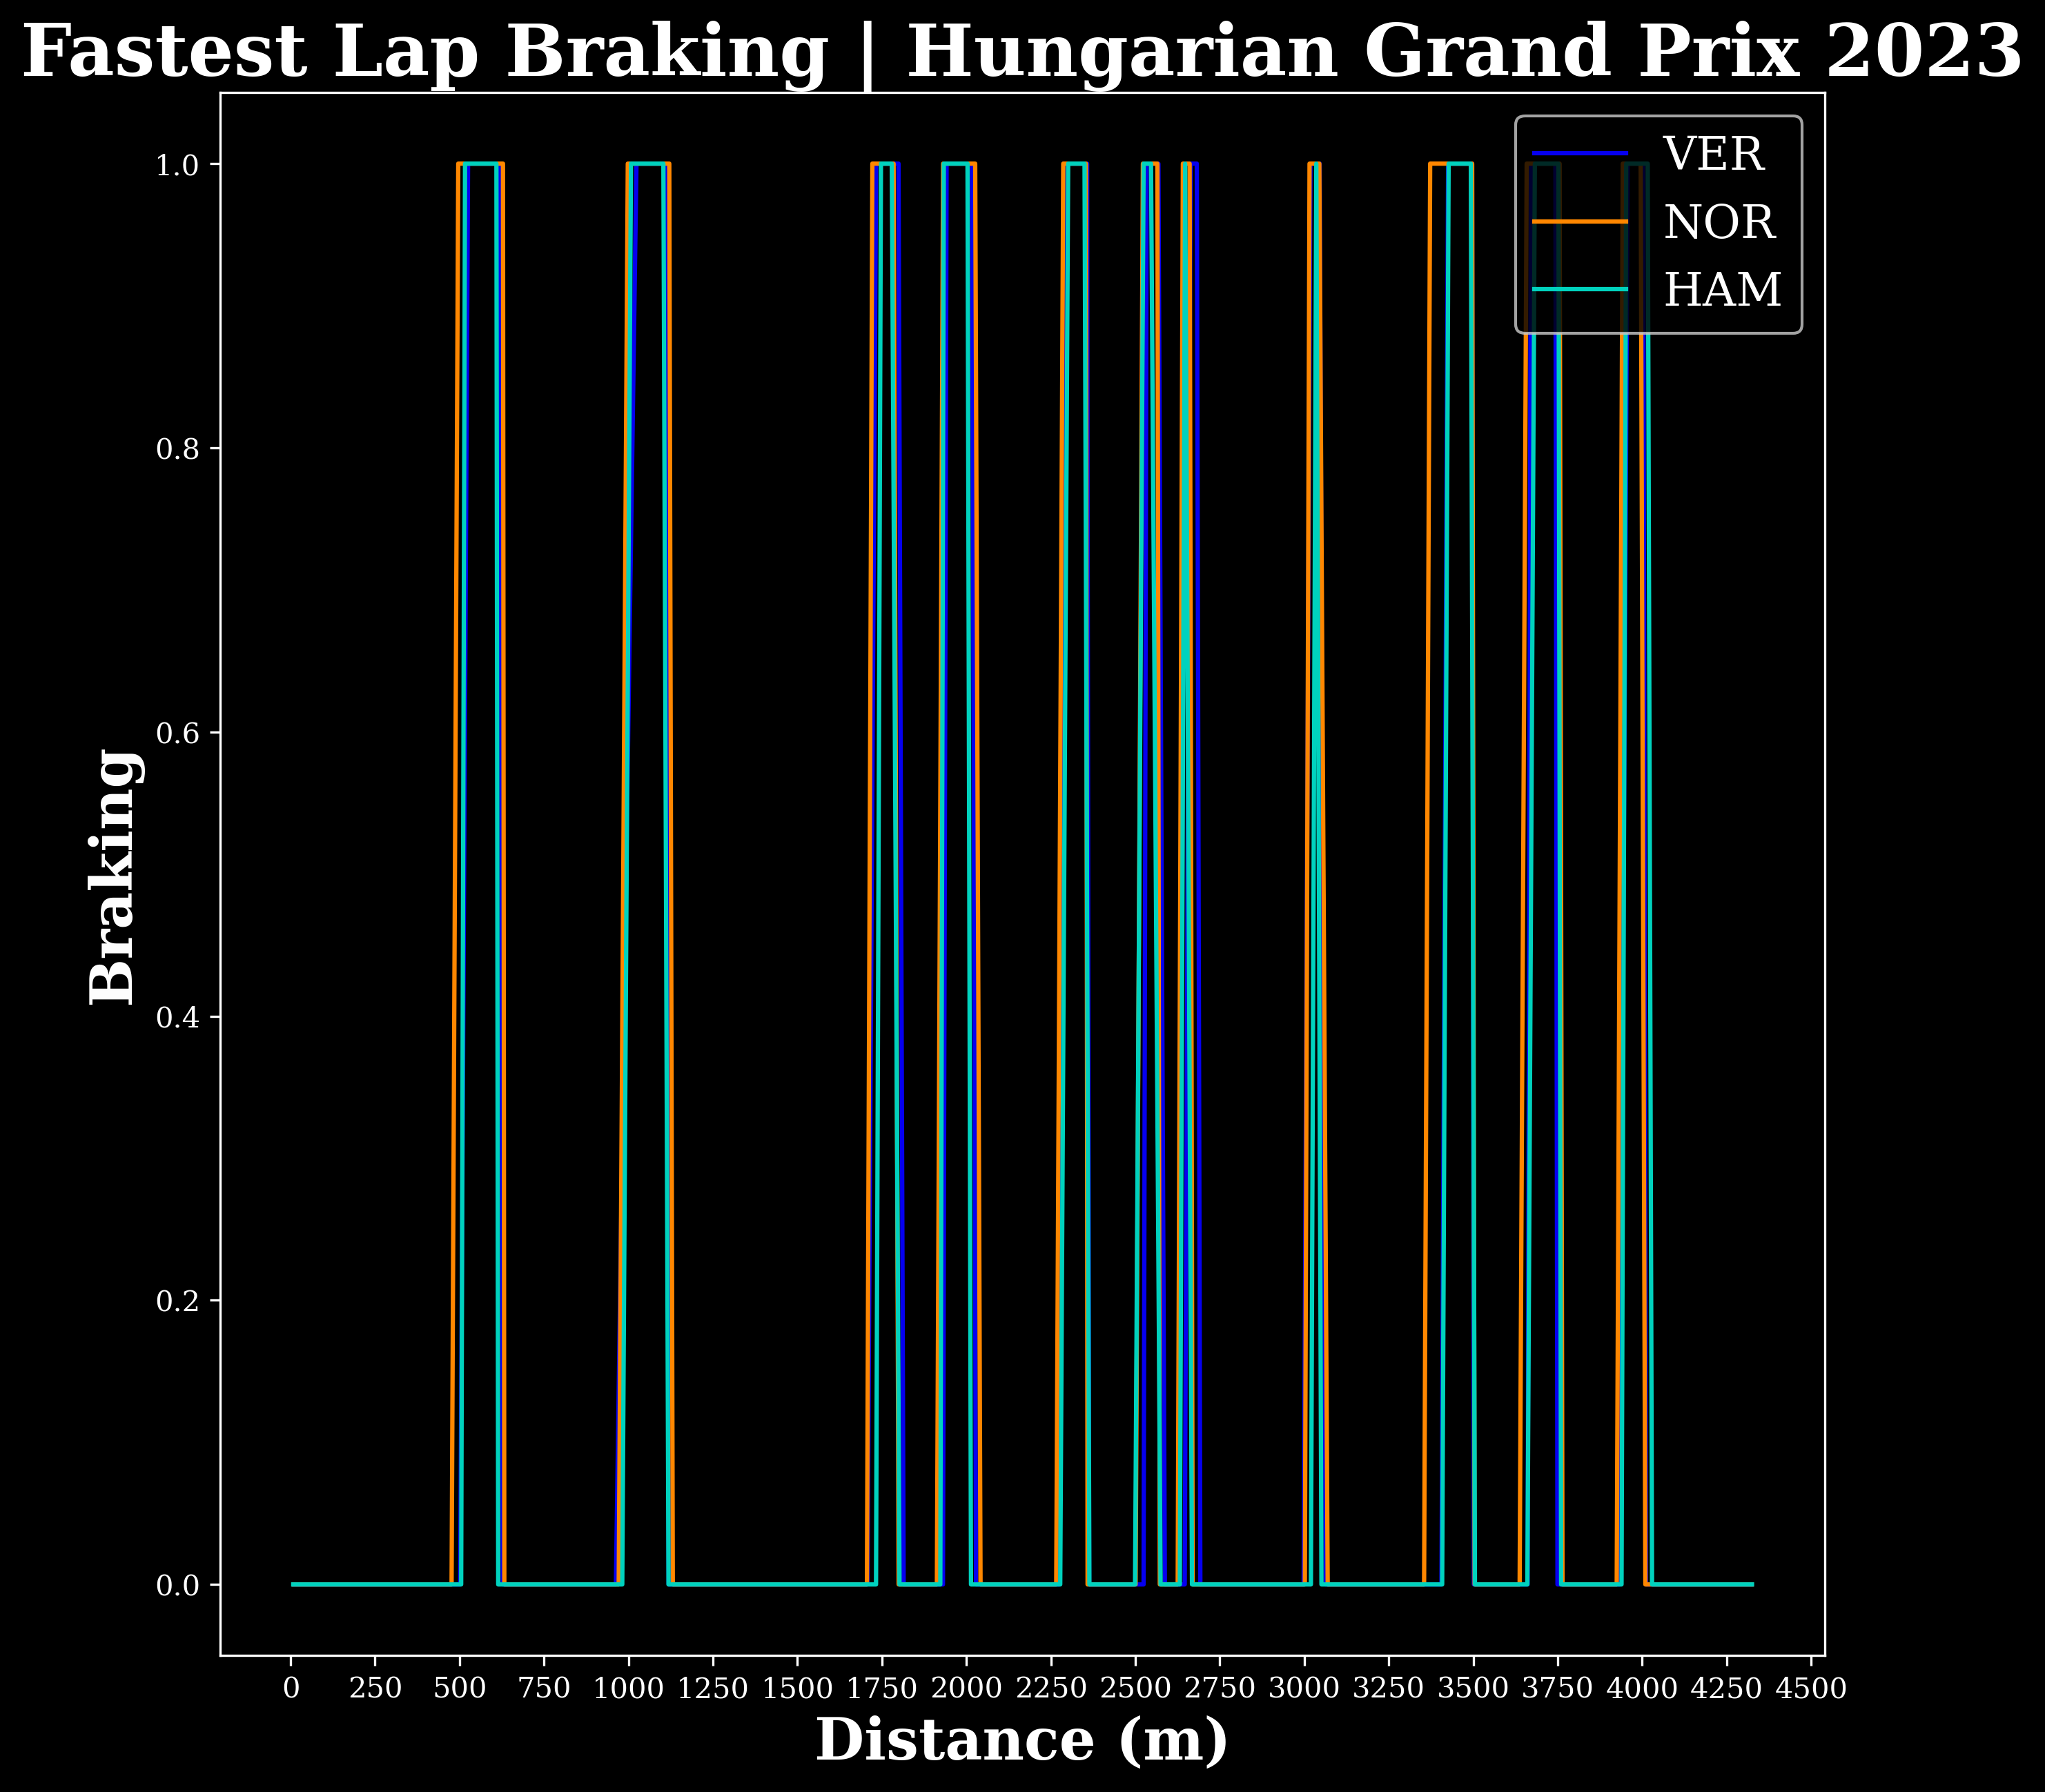

 The old property will be removed ina future version.
Use `Event['EventName']` or `Event.EventName` instead.


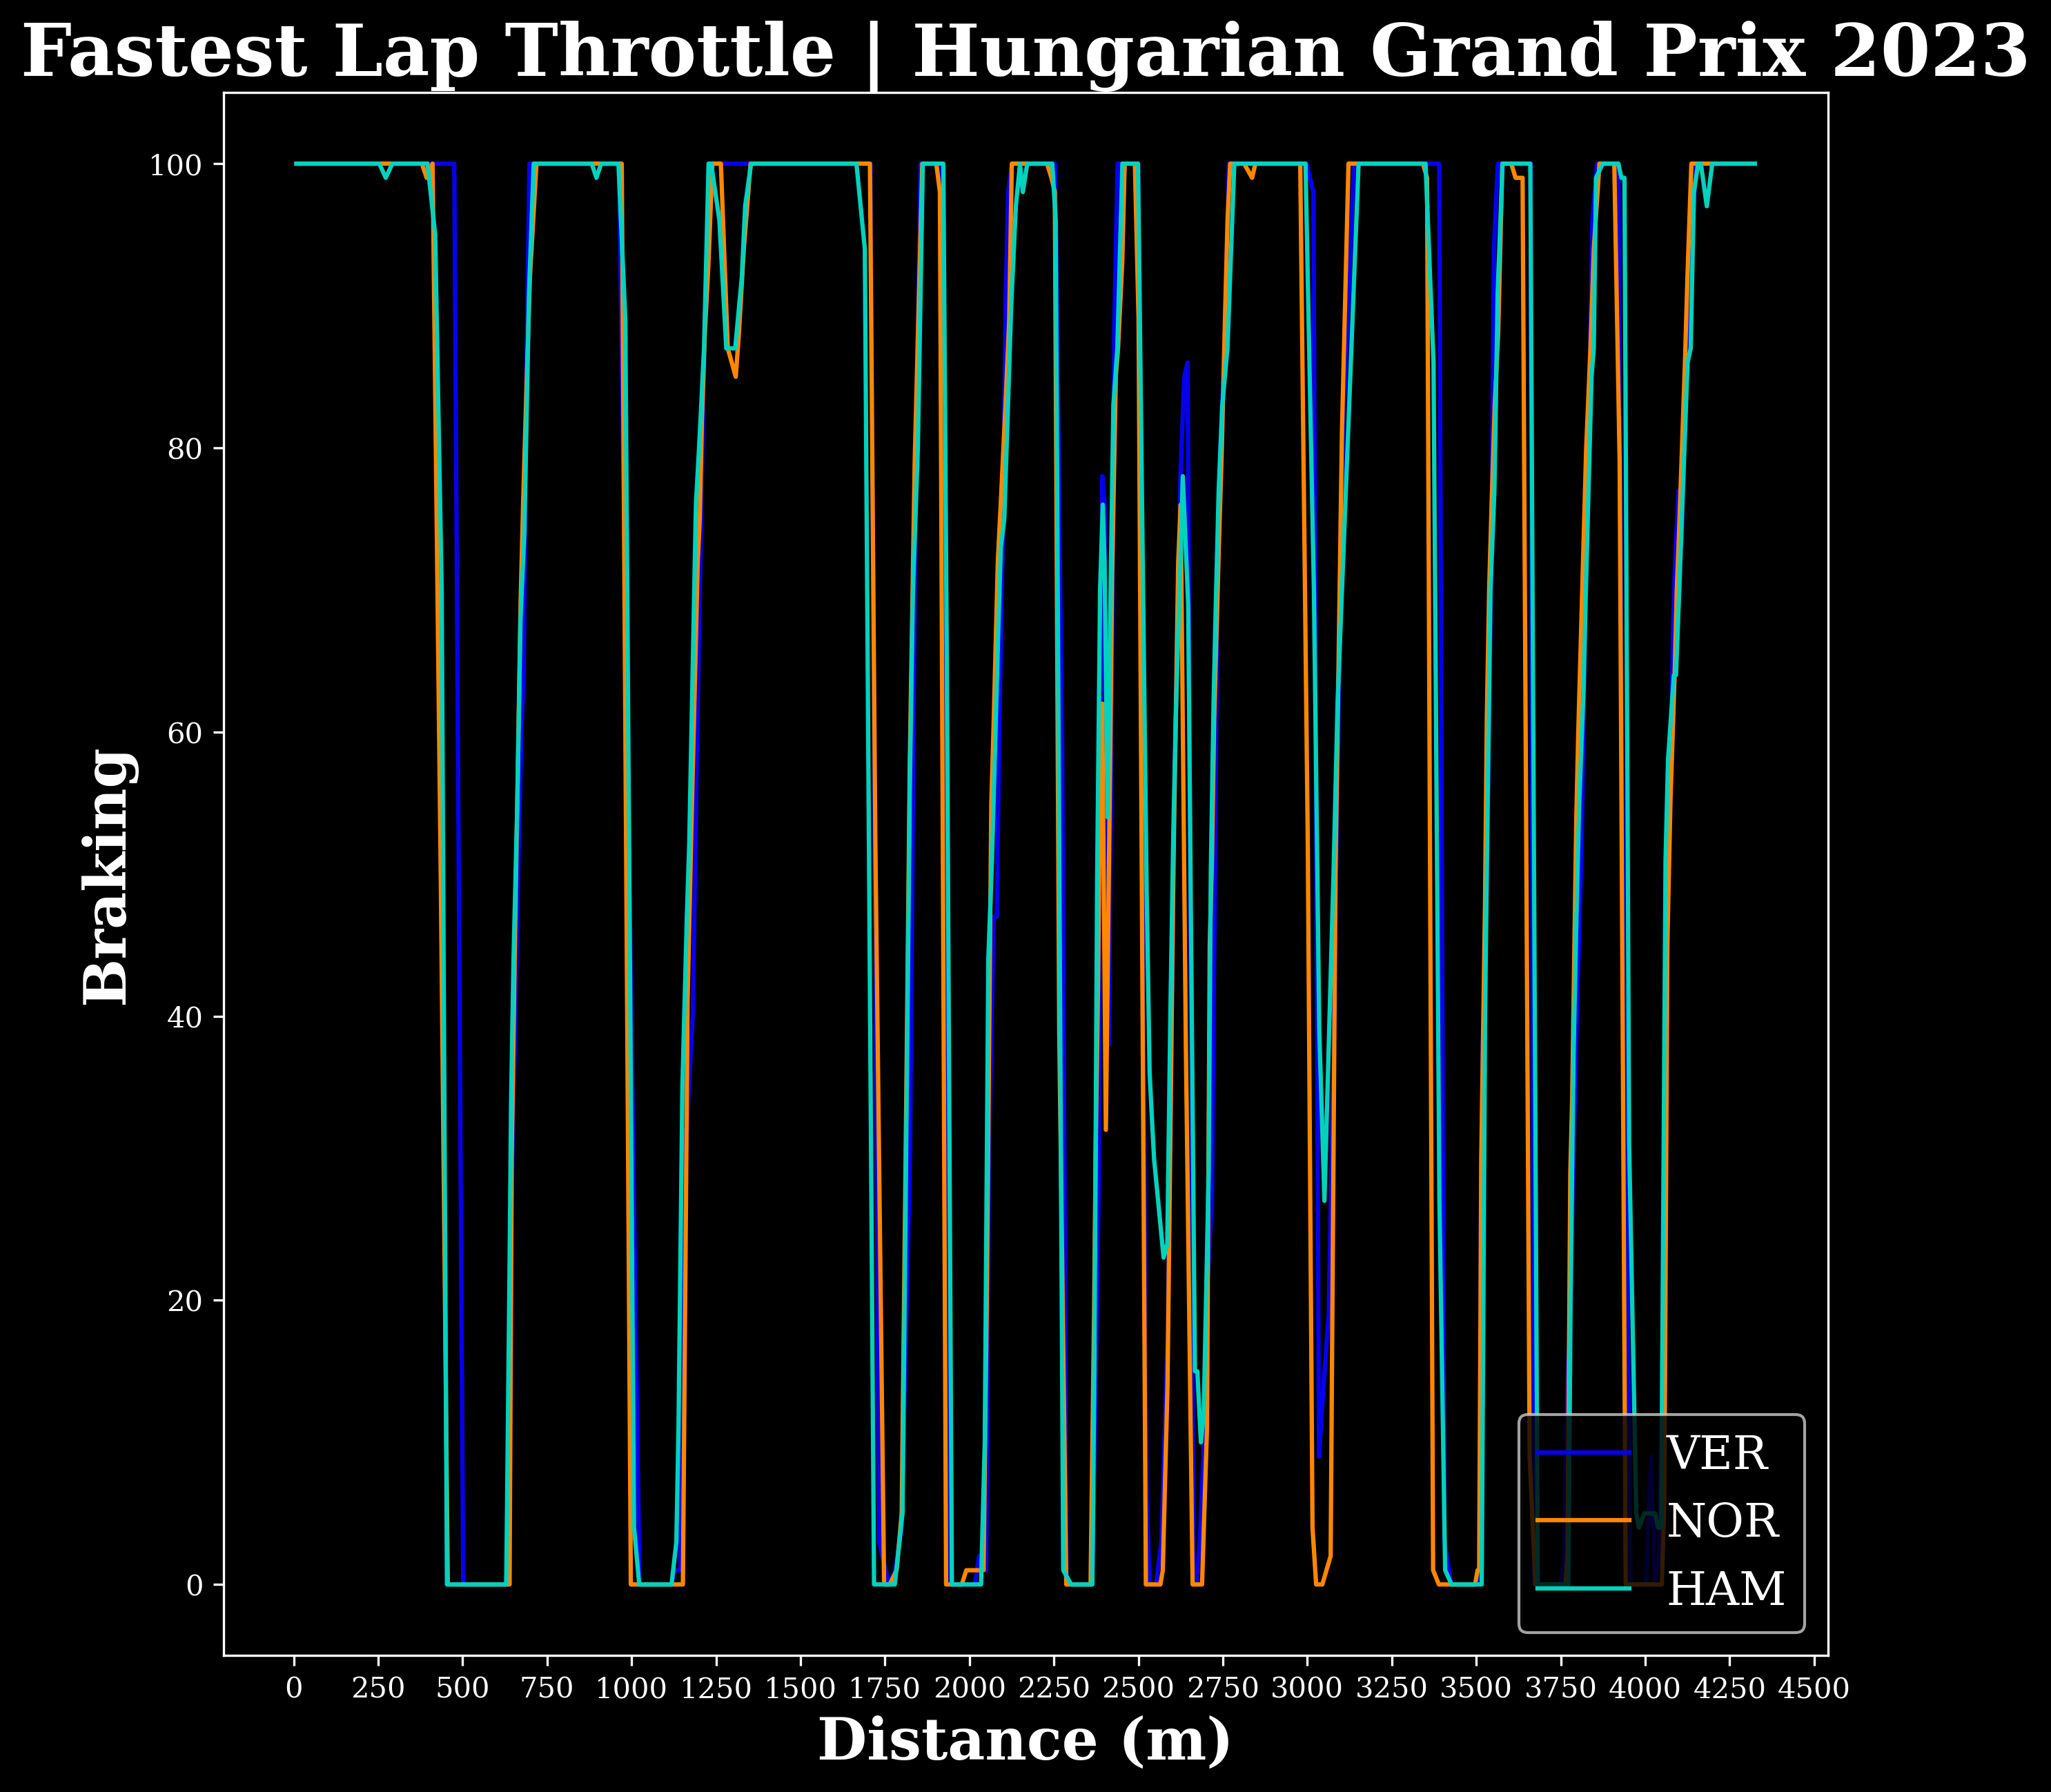

In [65]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.family'] = 'serif'
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 300

verlap=ver.pick_fastest()
leclap=lec.pick_fastest()
hamlap=ham.pick_fastest()
sailap=sai.pick_fastest()
norlap=nor.pick_fastest()


ver_tel = verlap.get_car_data().add_distance()
lec_tel = leclap.get_car_data().add_distance()
ham_tel = hamlap.get_car_data().add_distance()
sai_tel = sailap.get_car_data().add_distance()
nor_tel = norlap.get_car_data().add_distance()

rbr_color = ff1.plotting.team_color('RBR')
fer_color = ff1.plotting.team_color('FER')
mer_color = ff1.plotting.team_color('MER')
mcl_color = ff1.plotting.team_color('MCL')

#telemetry plot to show speed over the fastest lap
fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
# ax.plot(lec_tel['Distance'], lec_tel['Speed'], color=fer_color, label='LEC')
#same plot with norris telemetry
ax.plot(nor_tel['Distance'], nor_tel['Speed'], color=mcl_color, label='NOR')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')
ax.set_xlabel('Distance (m)', fontsize=20, fontweight='bold',color='white')
ax.set_ylabel('Speed (km/h)', fontsize=20, fontweight='bold',color='white')
plt.locator_params('x',nbins = 20)
plt.title(f'Fastest Lap Speed | {race.weekend.name} {race.weekend.year}', fontsize=25, fontweight='bold',color='White')
plt.legend(loc=3, prop={'size': 16})
plt.savefig(f'F1Plots/FastestLapCompSpeed {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

#telemetry plot to show braking points over the fastest lap
fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Brake'], color=rbr_color, label='VER')
ax.plot(nor_tel['Distance'], nor_tel['Brake'], color=mcl_color, label='NOR')
ax.plot(ham_tel['Distance'], ham_tel['Brake'], color=mer_color, label='HAM')
ax.set_xlabel('Distance (m)', fontsize=20, fontweight='bold',color='white')
ax.set_ylabel('Braking', fontsize=20, fontweight='bold',color='white')
plt.locator_params('x',nbins = 20)
plt.title(f'Fastest Lap Braking | {race.weekend.name} {race.weekend.year}', fontsize=25, fontweight='bold',color='White')
plt.legend(loc=1, prop={'size': 16})
plt.savefig(f'F1Plots/FastestLapCompBrake {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

#telemetry plot to show throttle over the fastest lap
fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Throttle'], color=rbr_color, label='VER')
ax.plot(nor_tel['Distance'], nor_tel['Throttle'], color= mcl_color, label='NOR')
ax.plot(ham_tel['Distance'], ham_tel['Throttle'], color=mer_color, label='HAM')
ax.set_xlabel('Distance (m)', fontsize=20, fontweight='bold',color='white')
ax.set_ylabel('Braking', fontsize=20, fontweight='bold',color='white')
plt.locator_params('x',nbins = 20)
plt.title(f'Fastest Lap Throttle | {race.weekend.name} {race.weekend.year}', fontsize=25, fontweight='bold',color='White')
plt.legend(loc=4, prop={'size': 16})
plt.savefig(f'F1Plots/FastestLapCompThrottle {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()

In [66]:
'''
#telemetry plot to show throttle over the fastest lap
fig, ax = plt.subplots()
ax.plot(sai_tel['Distance'], sai_tel['Throttle'], color='white', label='SAI',)
ax.plot(lec_tel['Distance'], lec_tel['Throttle'], color=fer_color, label='LEC')
ax.set_xlabel('Distance (m)', fontsize=20, fontweight='bold',color='white')
ax.set_ylabel('Throttle', fontsize=20, fontweight='bold',color='white')
plt.locator_params('x',nbins = 20)
plt.title(f'Fastest Lap Throttle | {race.weekend.name} {race.weekend.year}', fontsize=40, fontweight='bold',color='White')
plt.legend(loc=4, prop={'size': 16})
plt.savefig(f'F1Plots/FastestLapCompThrottleSaivLec {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')
plt.show()
'''

"\n#telemetry plot to show throttle over the fastest lap\nfig, ax = plt.subplots()\nax.plot(sai_tel['Distance'], sai_tel['Throttle'], color='white', label='SAI',)\nax.plot(lec_tel['Distance'], lec_tel['Throttle'], color=fer_color, label='LEC')\nax.set_xlabel('Distance (m)', fontsize=20, fontweight='bold',color='white')\nax.set_ylabel('Throttle', fontsize=20, fontweight='bold',color='white')\nplt.locator_params('x',nbins = 20)\nplt.title(f'Fastest Lap Throttle | {race.weekend.name} {race.weekend.year}', fontsize=40, fontweight='bold',color='White')\nplt.legend(loc=4, prop={'size': 16})\nplt.savefig(f'F1Plots/FastestLapCompThrottleSaivLec {race.weekend.name} {race.weekend.year}.png',bbox_inches='tight')\nplt.show()\n"